## LSTM For each SCALE

## Original

## Variogram 0.2 Non-scaled

In [5]:
# import LSTM libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import scipy
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse

#### Training Sets with sliding windows

In [186]:
training_set = pd.read_csv('datasets/orig_v1_0.csv') 

In [187]:
training_set = training_set.iloc[:,2:3].values

In [188]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

# create training and testing data 
seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [189]:
# Class LSTM remain the same across all LSTM creation
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [190]:
num_epochs = 2000
learning_rate = 0.03
# run epoches with changes in learning rate, p = dropout and epochs
input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.15072
Epoch: 100, loss: 0.04349
Epoch: 200, loss: 0.04181
Epoch: 300, loss: 0.04090
Epoch: 400, loss: 0.04083
Epoch: 500, loss: 0.04073
Epoch: 600, loss: 0.04055
Epoch: 700, loss: 0.04039
Epoch: 800, loss: 0.03990
Epoch: 900, loss: 0.03825
Epoch: 1000, loss: 0.03465
Epoch: 1100, loss: 0.03257
Epoch: 1200, loss: 0.03123
Epoch: 1300, loss: 0.02993
Epoch: 1400, loss: 0.02857
Epoch: 1500, loss: 0.02813
Epoch: 1600, loss: 0.02796
Epoch: 1700, loss: 0.02794
Epoch: 1800, loss: 0.02784
Epoch: 1900, loss: 0.02778


Text(0, 0.5, 'Loss')

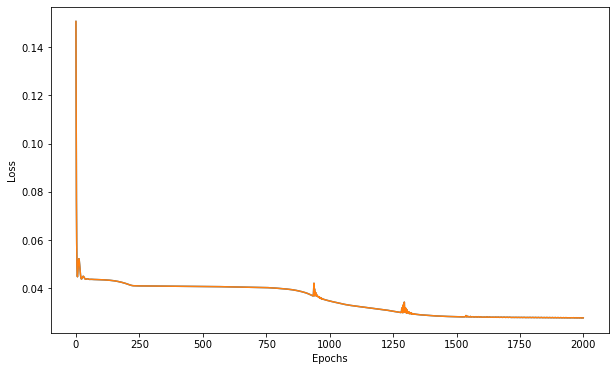

In [191]:
# Loss plots
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Non scaled data for each y value constant

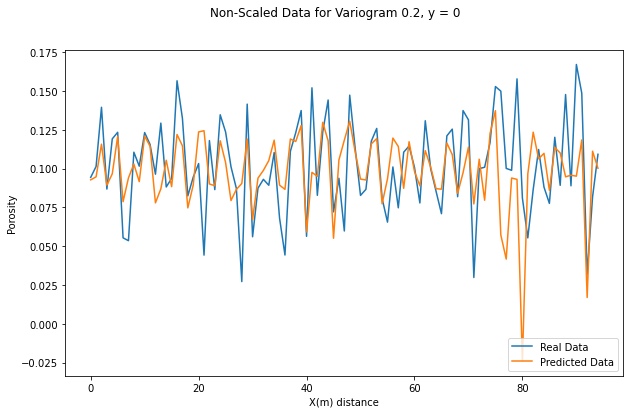

In [192]:
# Non scaled data for each y value constant
lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 0')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.43707465755985814, pvalue=9.486955457476494e-06)
STD: 0.029291652
MSE: 0.0008692391


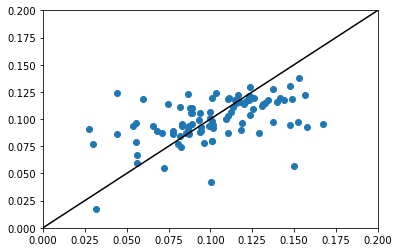

In [193]:
# complete pearson correlation and mse plotted on a one-to-one line
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.19093
Epoch: 100, loss: 0.04821
Epoch: 200, loss: 0.04800
Epoch: 300, loss: 0.04786
Epoch: 400, loss: 0.04774
Epoch: 500, loss: 0.04765
Epoch: 600, loss: 0.04756
Epoch: 700, loss: 0.04744
Epoch: 800, loss: 0.04712
Epoch: 900, loss: 0.03953
Epoch: 1000, loss: 0.03250
Epoch: 1100, loss: 0.03122
Epoch: 1200, loss: 0.03029
Epoch: 1300, loss: 0.02919
Epoch: 1400, loss: 0.02722
Epoch: 1500, loss: 0.02518
Epoch: 1600, loss: 0.02395
Epoch: 1700, loss: 0.02333
Epoch: 1800, loss: 0.02244
Epoch: 1900, loss: 0.02217


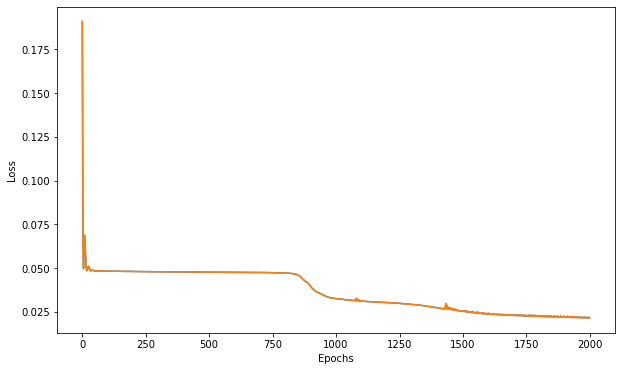

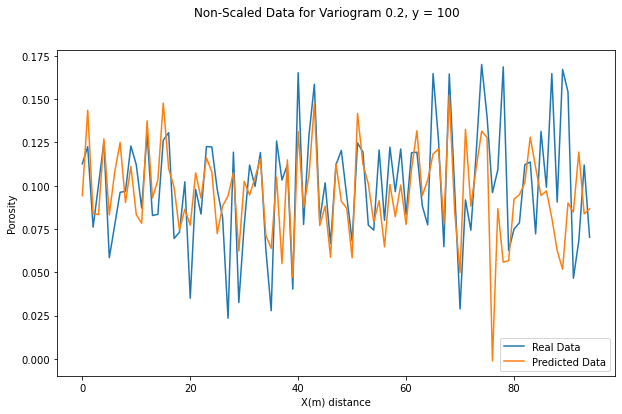

In [194]:
training_set = pd.read_csv('datasets/orig_v1_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 100')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.48027607017467805, pvalue=8.419555816104771e-07)
STD: 0.030738275
MSE: 0.0009668612


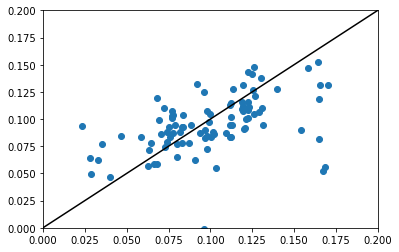

In [195]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.12815
Epoch: 100, loss: 0.01447
Epoch: 200, loss: 0.01446
Epoch: 300, loss: 0.01446
Epoch: 400, loss: 0.01445
Epoch: 500, loss: 0.01444
Epoch: 600, loss: 0.01443
Epoch: 700, loss: 0.01442
Epoch: 800, loss: 0.01438
Epoch: 900, loss: 0.01430
Epoch: 1000, loss: 0.01417
Epoch: 1100, loss: 0.01391
Epoch: 1200, loss: 0.01274
Epoch: 1300, loss: 0.01207
Epoch: 1400, loss: 0.01146
Epoch: 1500, loss: 0.01109
Epoch: 1600, loss: 0.01073
Epoch: 1700, loss: 0.01038
Epoch: 1800, loss: 0.01009
Epoch: 1900, loss: 0.00973


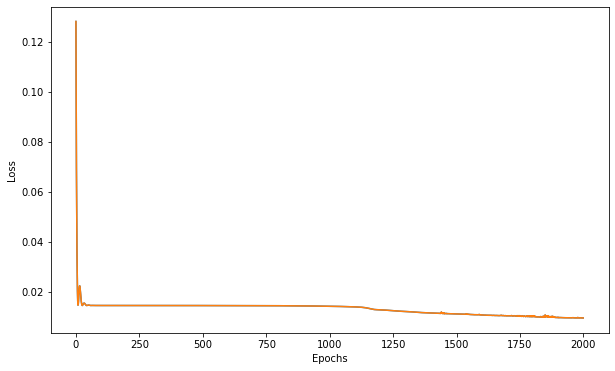

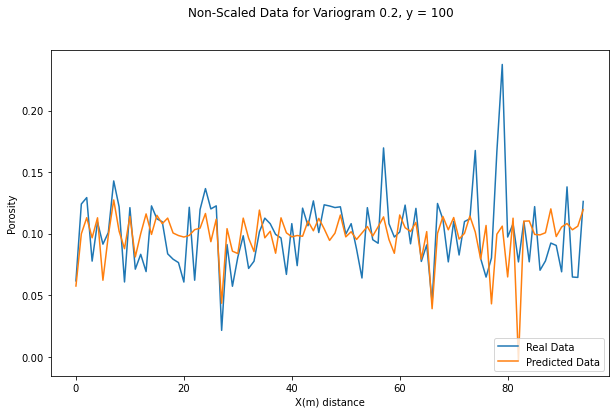

In [196]:
training_set = pd.read_csv('datasets/orig_v1_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 100')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.40925661811511715, pvalue=3.821724395211165e-05)
STD: 0.028163219
MSE: 0.0007951964


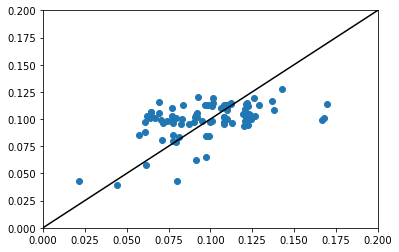

In [197]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.10726
Epoch: 100, loss: 0.04394
Epoch: 200, loss: 0.04376
Epoch: 300, loss: 0.04329
Epoch: 400, loss: 0.04119
Epoch: 500, loss: 0.03882
Epoch: 600, loss: 0.03337
Epoch: 700, loss: 0.03131
Epoch: 800, loss: 0.02879
Epoch: 900, loss: 0.02333
Epoch: 1000, loss: 0.02017
Epoch: 1100, loss: 0.01826
Epoch: 1200, loss: 0.01740
Epoch: 1300, loss: 0.01705
Epoch: 1400, loss: 0.01685
Epoch: 1500, loss: 0.01666
Epoch: 1600, loss: 0.01643
Epoch: 1700, loss: 0.01545
Epoch: 1800, loss: 0.01499
Epoch: 1900, loss: 0.01467


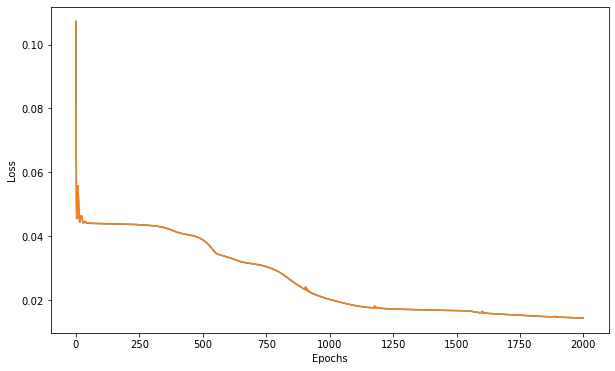

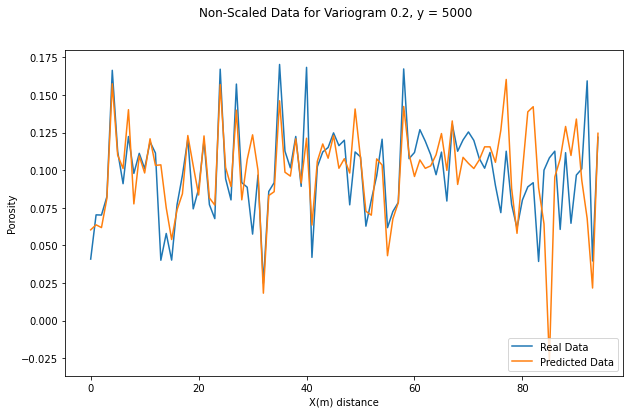

In [198]:
training_set = pd.read_csv('datasets/orig_v1_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 5000')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.5922775695220969, pvalue=2.580725198532358e-10)
STD: 0.027242742
MSE: 0.00074403663


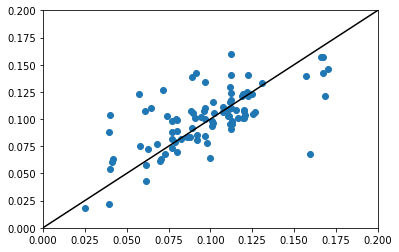

In [199]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.02352
Epoch: 100, loss: 0.02252
Epoch: 200, loss: 0.02210
Epoch: 300, loss: 0.02088
Epoch: 400, loss: 0.02026
Epoch: 500, loss: 0.01996
Epoch: 600, loss: 0.01973
Epoch: 700, loss: 0.01927
Epoch: 800, loss: 0.01881
Epoch: 900, loss: 0.01803
Epoch: 1000, loss: 0.01658
Epoch: 1100, loss: 0.01512
Epoch: 1200, loss: 0.01415
Epoch: 1300, loss: 0.01390
Epoch: 1400, loss: 0.01364
Epoch: 1500, loss: 0.01338
Epoch: 1600, loss: 0.01331
Epoch: 1700, loss: 0.01317
Epoch: 1800, loss: 0.01306
Epoch: 1900, loss: 0.01299


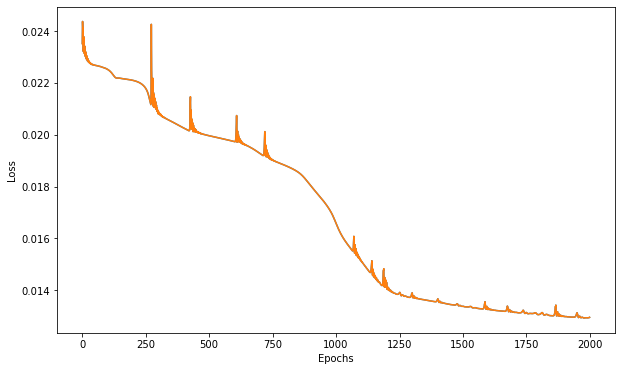

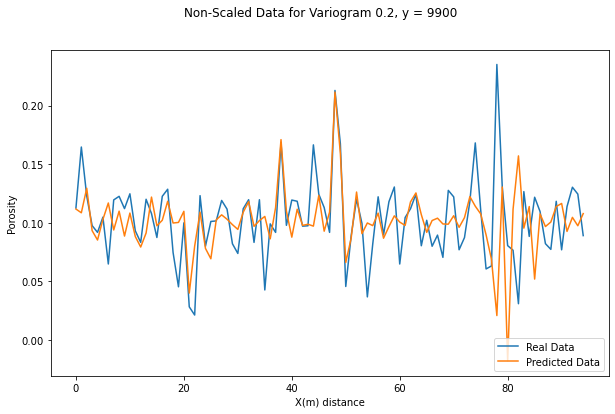

In [200]:
training_set = pd.read_csv('datasets/orig_v1_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 9900')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.2795509373146873, pvalue=0.0060773003235222575)
STD: 0.03695498
MSE: 0.001367722


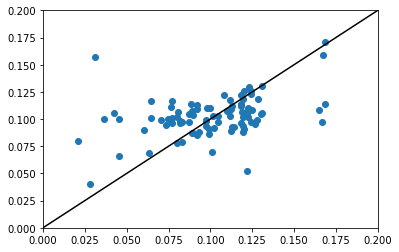

In [201]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new5 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse5 = mse(dataY_plot[:,0], data_predict[:,0])
real_d5 = dataY_plot[:,0]
pred_d5 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

### Y constant for each model 0.2

Average Pearson:  0.43968717053728745
Average MSE:  0.0009486110880970955


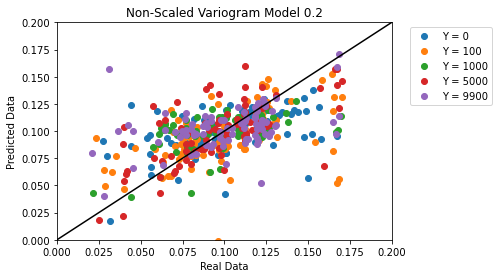

In [202]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 0')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 100')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 1000')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 5000')
plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Non-Scaled Variogram Model 0.2")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.legend(["0", "100", "5000", "9900"], loc ="upper left")
#print(new5[0])

In [203]:
# creating array for predicted and real data for overall non-scaled
con1 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4, pred_d5)) 
real1 = np.concatenate((real_d1, real_d2, real_d3, real_d4, real_d5))

## Variogram 0.4 Non-scaled

Epoch: 0, loss: 1.33235
Epoch: 100, loss: 0.02743
Epoch: 200, loss: 0.01380
Epoch: 300, loss: 0.00689
Epoch: 400, loss: 0.00467
Epoch: 500, loss: 0.00327
Epoch: 600, loss: 0.00275
Epoch: 700, loss: 0.00259
Epoch: 800, loss: 0.00252
Epoch: 900, loss: 0.00247
Epoch: 1000, loss: 0.00245
Epoch: 1100, loss: 0.00243
Epoch: 1200, loss: 0.00241
Epoch: 1300, loss: 0.00240
Epoch: 1400, loss: 0.00238
Epoch: 1500, loss: 0.00236
Epoch: 1600, loss: 0.00234
Epoch: 1700, loss: 0.00230
Epoch: 1800, loss: 0.00225
Epoch: 1900, loss: 0.00220


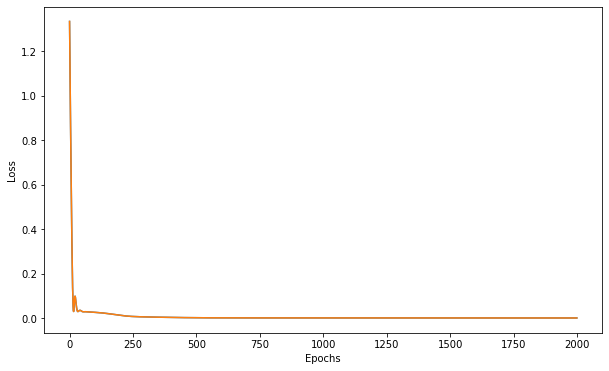

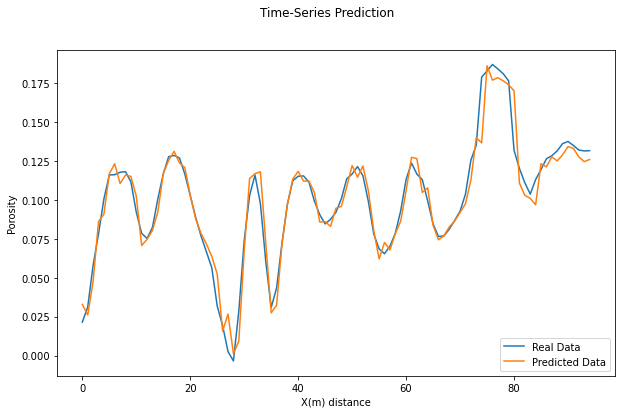

In [204]:
training_set = pd.read_csv('datasets/orig_sim2_0.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.968729713131779, pvalue=4.2984743442394705e-58)
STD: 0.009297223
MSE: 8.684219e-05


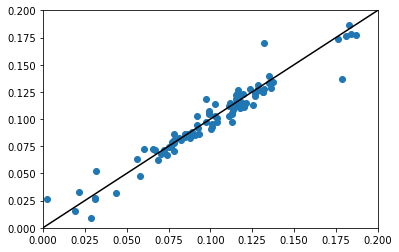

In [205]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.11052
Epoch: 100, loss: 0.00304
Epoch: 200, loss: 0.00205
Epoch: 300, loss: 0.00196
Epoch: 400, loss: 0.00190
Epoch: 500, loss: 0.00185
Epoch: 600, loss: 0.00176
Epoch: 700, loss: 0.00169
Epoch: 800, loss: 0.00165
Epoch: 900, loss: 0.00162
Epoch: 1000, loss: 0.00160
Epoch: 1100, loss: 0.00157
Epoch: 1200, loss: 0.00155
Epoch: 1300, loss: 0.00151
Epoch: 1400, loss: 0.00145
Epoch: 1500, loss: 0.00138
Epoch: 1600, loss: 0.00133
Epoch: 1700, loss: 0.00130
Epoch: 1800, loss: 0.00126
Epoch: 1900, loss: 0.00118


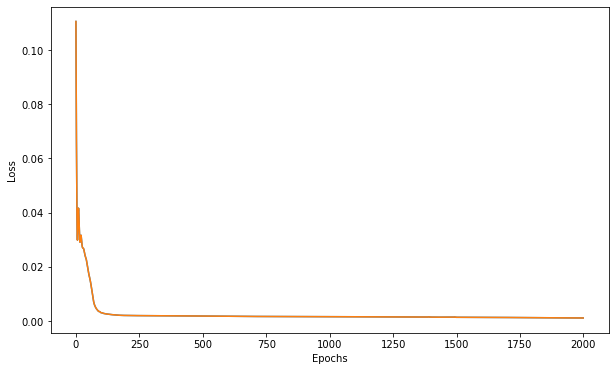

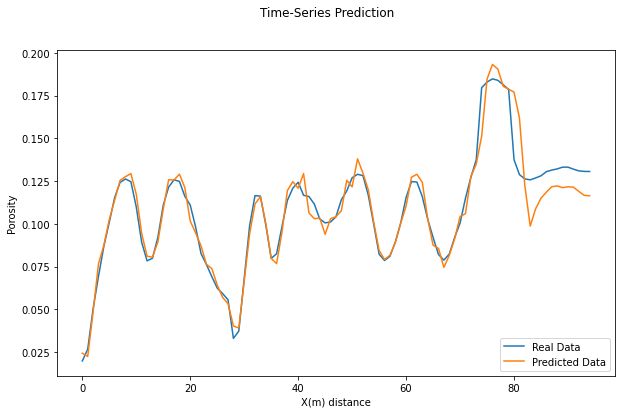

In [206]:
training_set = pd.read_csv('datasets/orig_sim2_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9620367716643756, pvalue=3.0495820333369196e-54)
STD: 0.008911147
MSE: 8.0129124e-05


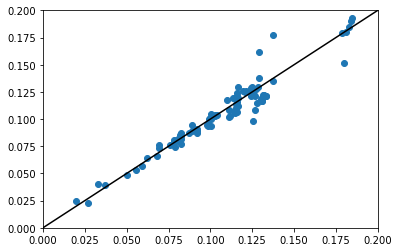

In [207]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.13033
Epoch: 100, loss: 0.00470
Epoch: 200, loss: 0.00196
Epoch: 300, loss: 0.00191
Epoch: 400, loss: 0.00187
Epoch: 500, loss: 0.00183
Epoch: 600, loss: 0.00179
Epoch: 700, loss: 0.00175
Epoch: 800, loss: 0.00171
Epoch: 900, loss: 0.00167
Epoch: 1000, loss: 0.00165
Epoch: 1100, loss: 0.00163
Epoch: 1200, loss: 0.00162
Epoch: 1300, loss: 0.00161
Epoch: 1400, loss: 0.00160
Epoch: 1500, loss: 0.00160
Epoch: 1600, loss: 0.00159
Epoch: 1700, loss: 0.00158
Epoch: 1800, loss: 0.00158
Epoch: 1900, loss: 0.00158


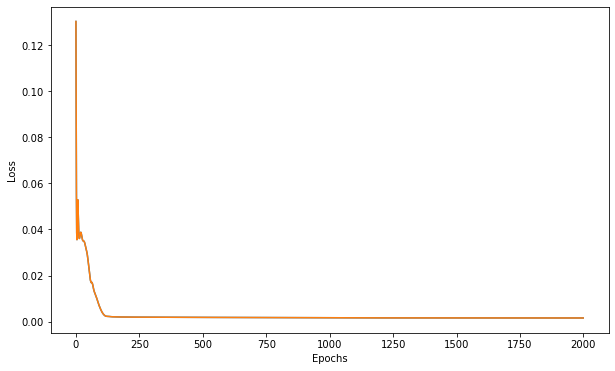

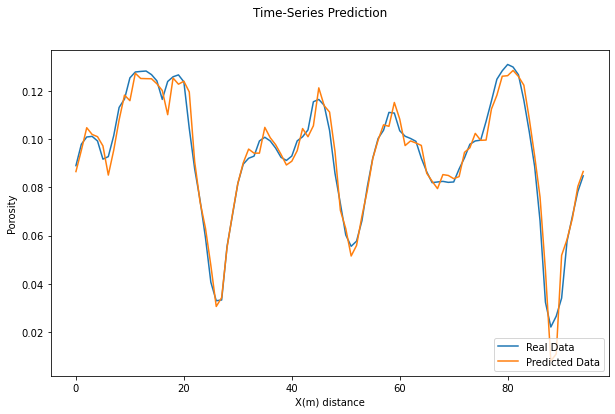

In [208]:
training_set = pd.read_csv('datasets/orig_sim2_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9782993326260084, pvalue=2.2357923769167354e-65)
STD: 0.005315576
MSE: 2.8256974e-05


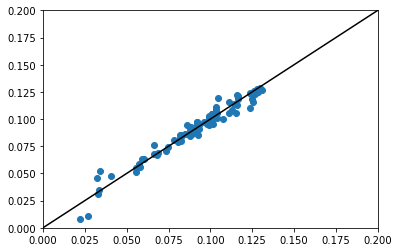

In [209]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 2.24594
Epoch: 100, loss: 0.01686
Epoch: 200, loss: 0.00512
Epoch: 300, loss: 0.00444
Epoch: 400, loss: 0.00233
Epoch: 500, loss: 0.00222
Epoch: 600, loss: 0.00218
Epoch: 700, loss: 0.00216
Epoch: 800, loss: 0.00215
Epoch: 900, loss: 0.00214
Epoch: 1000, loss: 0.00213
Epoch: 1100, loss: 0.00211
Epoch: 1200, loss: 0.00210
Epoch: 1300, loss: 0.00209
Epoch: 1400, loss: 0.00207
Epoch: 1500, loss: 0.00206
Epoch: 1600, loss: 0.00204
Epoch: 1700, loss: 0.00202
Epoch: 1800, loss: 0.00200
Epoch: 1900, loss: 0.00198


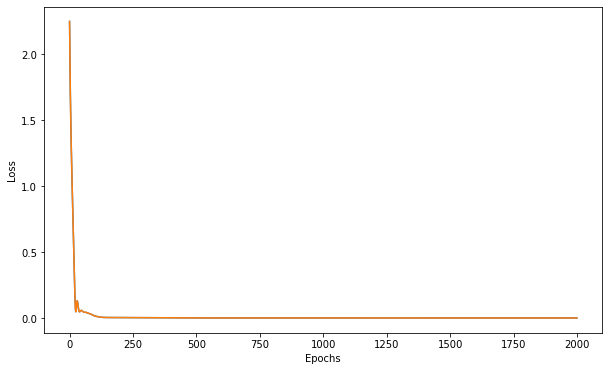

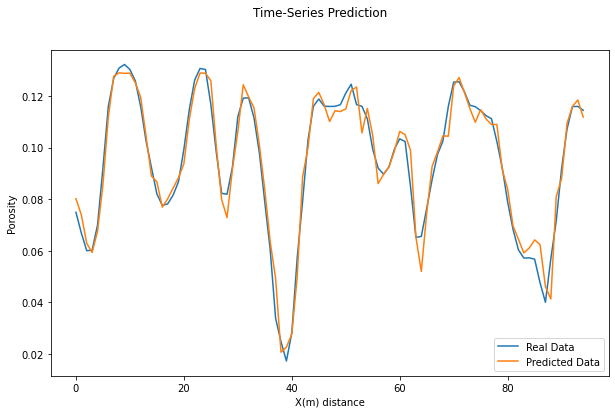

In [210]:
training_set = pd.read_csv('datasets/orig_sim2_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9799759763189034, pvalue=5.520155305450574e-67)
STD: 0.005373082
MSE: 2.9041714e-05


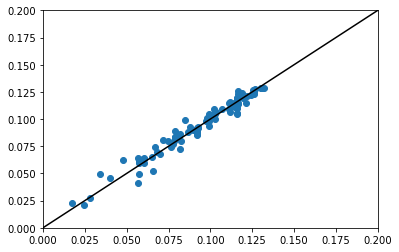

In [211]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.54195
Epoch: 100, loss: 0.04082
Epoch: 200, loss: 0.01288
Epoch: 300, loss: 0.00549
Epoch: 400, loss: 0.00367
Epoch: 500, loss: 0.00309
Epoch: 600, loss: 0.00285
Epoch: 700, loss: 0.00267
Epoch: 800, loss: 0.00250
Epoch: 900, loss: 0.00232
Epoch: 1000, loss: 0.00215
Epoch: 1100, loss: 0.00198
Epoch: 1200, loss: 0.00182
Epoch: 1300, loss: 0.00170
Epoch: 1400, loss: 0.00160
Epoch: 1500, loss: 0.00154
Epoch: 1600, loss: 0.00150
Epoch: 1700, loss: 0.00148
Epoch: 1800, loss: 0.00147
Epoch: 1900, loss: 0.00146


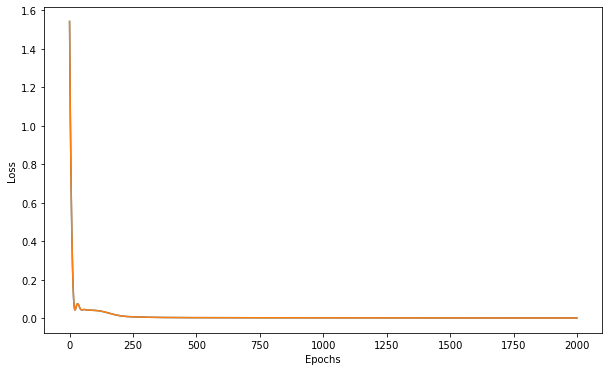

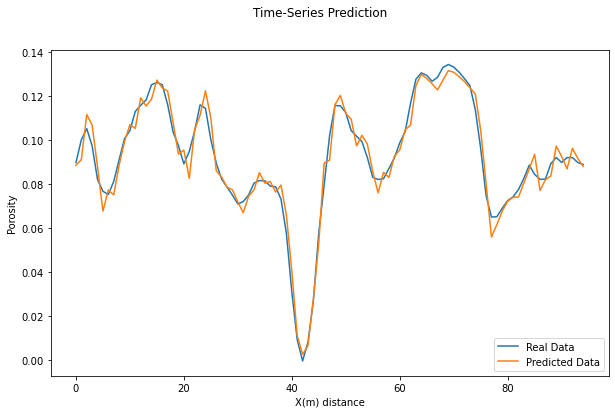

In [212]:
training_set = pd.read_csv('datasets/orig_sim2_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9821180814459466, pvalue=3.00592873203451e-69)
STD: 0.004995643
MSE: 2.4965406e-05


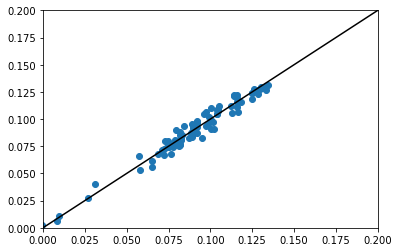

In [213]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new5 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse5 = mse(dataY_plot[:,0], data_predict[:,0])
real_d5 = dataY_plot[:,0]
pred_d5 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.9742319750374027
Average MSE:  4.9847079208120706e-05


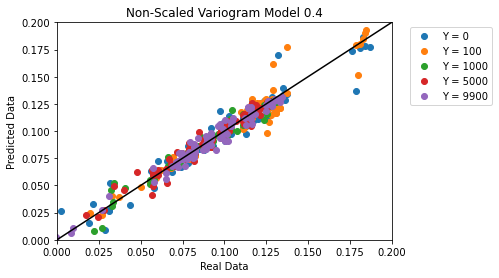

In [214]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 0')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 100')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 1000')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 5000')
plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Non-Scaled Variogram Model 0.4")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.legend(["0", "100", "5000", "9900"], loc ="upper left")
#print(new5[0])

In [215]:
con2 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4, pred_d5))
real2 = np.concatenate((real_d1, real_d2, real_d3, real_d4, real_d5))

## Variogram 0.6 Non-scaled

Epoch: 0, loss: 0.03411
Epoch: 100, loss: 0.00172
Epoch: 200, loss: 0.00071
Epoch: 300, loss: 0.00069
Epoch: 400, loss: 0.00068
Epoch: 500, loss: 0.00067
Epoch: 600, loss: 0.00066
Epoch: 700, loss: 0.00065
Epoch: 800, loss: 0.00065
Epoch: 900, loss: 0.00064
Epoch: 1000, loss: 0.00063
Epoch: 1100, loss: 0.00062
Epoch: 1200, loss: 0.00060
Epoch: 1300, loss: 0.00058
Epoch: 1400, loss: 0.00055
Epoch: 1500, loss: 0.00052
Epoch: 1600, loss: 0.00051
Epoch: 1700, loss: 0.00050
Epoch: 1800, loss: 0.00049
Epoch: 1900, loss: 0.00048


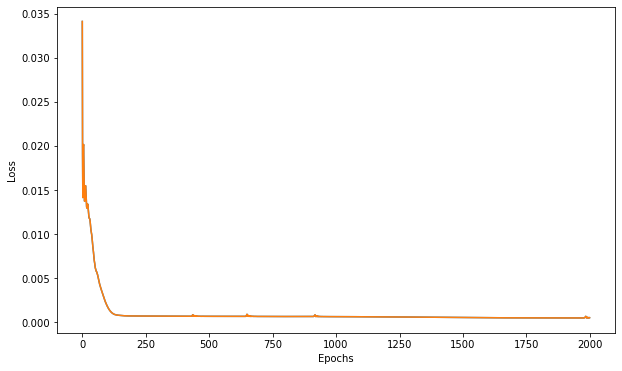

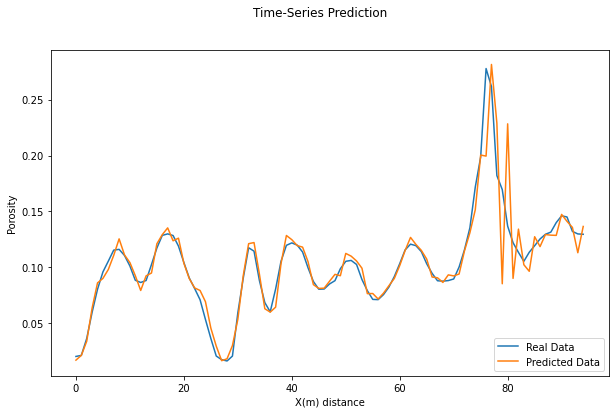

In [216]:
training_set = pd.read_csv('datasets/orig_sim3_0.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9138415889150575, pvalue=3.5870110586901873e-38)
STD: 0.01754616
MSE: 0.00030793174


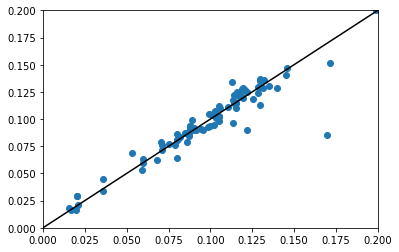

In [217]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.60865
Epoch: 100, loss: 0.01702
Epoch: 200, loss: 0.00531
Epoch: 300, loss: 0.00144
Epoch: 400, loss: 0.00081
Epoch: 500, loss: 0.00071
Epoch: 600, loss: 0.00069
Epoch: 700, loss: 0.00069
Epoch: 800, loss: 0.00069
Epoch: 900, loss: 0.00068
Epoch: 1000, loss: 0.00068
Epoch: 1100, loss: 0.00068
Epoch: 1200, loss: 0.00068
Epoch: 1300, loss: 0.00068
Epoch: 1400, loss: 0.00068
Epoch: 1500, loss: 0.00068
Epoch: 1600, loss: 0.00068
Epoch: 1700, loss: 0.00068
Epoch: 1800, loss: 0.00068
Epoch: 1900, loss: 0.00068


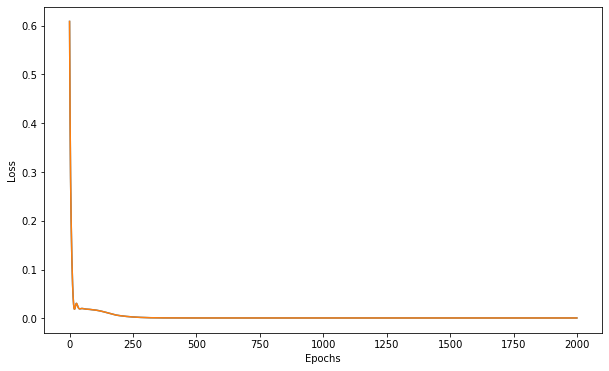

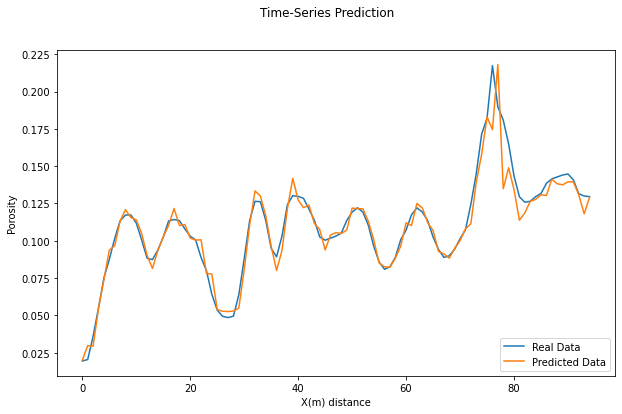

In [218]:
training_set = pd.read_csv('datasets/orig_sim3_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9636798270411067, pvalue=4.044941678780845e-55)
STD: 0.008862685
MSE: 8.104864e-05


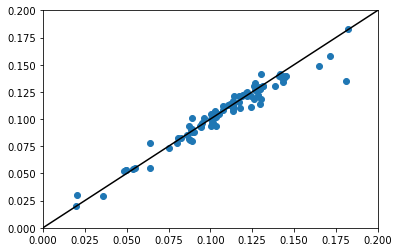

In [219]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.29154
Epoch: 100, loss: 0.01587
Epoch: 200, loss: 0.00572
Epoch: 300, loss: 0.00465
Epoch: 400, loss: 0.00400
Epoch: 500, loss: 0.00339
Epoch: 600, loss: 0.00214
Epoch: 700, loss: 0.00175
Epoch: 800, loss: 0.00166
Epoch: 900, loss: 0.00160
Epoch: 1000, loss: 0.00156
Epoch: 1100, loss: 0.00153
Epoch: 1200, loss: 0.00150
Epoch: 1300, loss: 0.00149
Epoch: 1400, loss: 0.00148
Epoch: 1500, loss: 0.00147
Epoch: 1600, loss: 0.00146
Epoch: 1700, loss: 0.00146
Epoch: 1800, loss: 0.00145
Epoch: 1900, loss: 0.00145


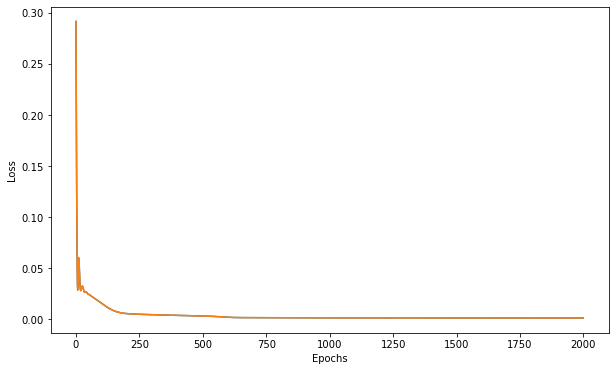

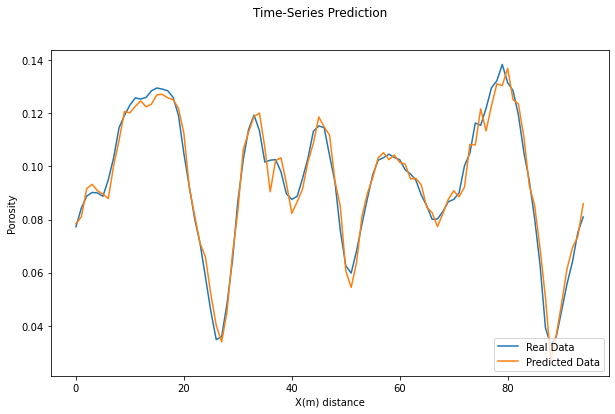

In [220]:
training_set = pd.read_csv('datasets/orig_sim3_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9850643826501302, pvalue=7.427172774787209e-73)
STD: 0.0043731052
MSE: 1.9170091e-05


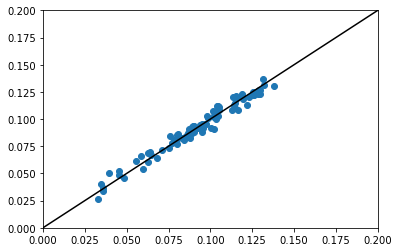

In [221]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new5 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse5 = mse(dataY_plot[:,0], data_predict[:,0])
real_d5 = dataY_plot[:,0]
pred_d5 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.43009
Epoch: 100, loss: 0.01855
Epoch: 200, loss: 0.00800
Epoch: 300, loss: 0.00356
Epoch: 400, loss: 0.00174
Epoch: 500, loss: 0.00158
Epoch: 600, loss: 0.00151
Epoch: 700, loss: 0.00148
Epoch: 800, loss: 0.00147
Epoch: 900, loss: 0.00146
Epoch: 1000, loss: 0.00146
Epoch: 1100, loss: 0.00145
Epoch: 1200, loss: 0.00145
Epoch: 1300, loss: 0.00145
Epoch: 1400, loss: 0.00145
Epoch: 1500, loss: 0.00145
Epoch: 1600, loss: 0.00144
Epoch: 1700, loss: 0.00144
Epoch: 1800, loss: 0.00144
Epoch: 1900, loss: 0.00144


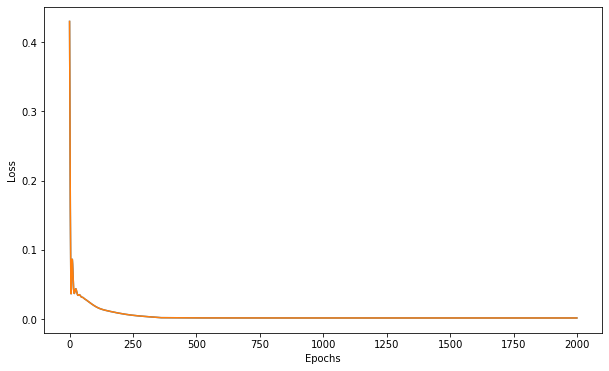

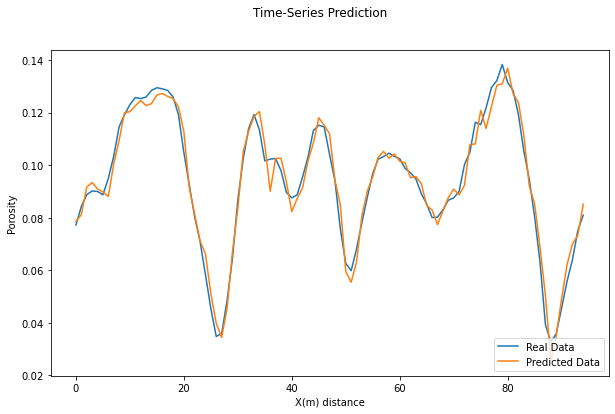

In [222]:
training_set = pd.read_csv('datasets/orig_sim3_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9849917159508806, pvalue=9.292470411595784e-73)
STD: 0.004373935
MSE: 1.9176243e-05


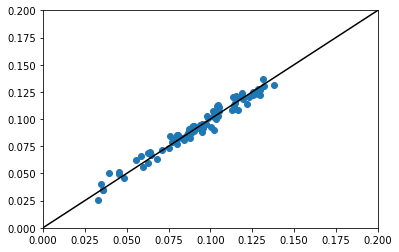

In [223]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.83341
Epoch: 100, loss: 0.01966
Epoch: 200, loss: 0.01067
Epoch: 300, loss: 0.00747
Epoch: 400, loss: 0.00603
Epoch: 500, loss: 0.00507
Epoch: 600, loss: 0.00419
Epoch: 700, loss: 0.00281
Epoch: 800, loss: 0.00231
Epoch: 900, loss: 0.00222
Epoch: 1000, loss: 0.00215
Epoch: 1100, loss: 0.00210
Epoch: 1200, loss: 0.00206
Epoch: 1300, loss: 0.00202
Epoch: 1400, loss: 0.00199
Epoch: 1500, loss: 0.00196
Epoch: 1600, loss: 0.00194
Epoch: 1700, loss: 0.00193
Epoch: 1800, loss: 0.00191
Epoch: 1900, loss: 0.00190


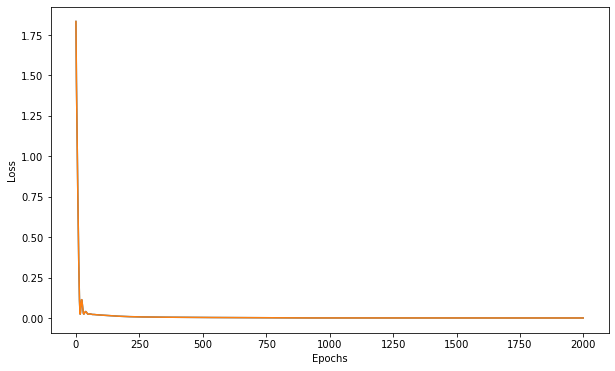

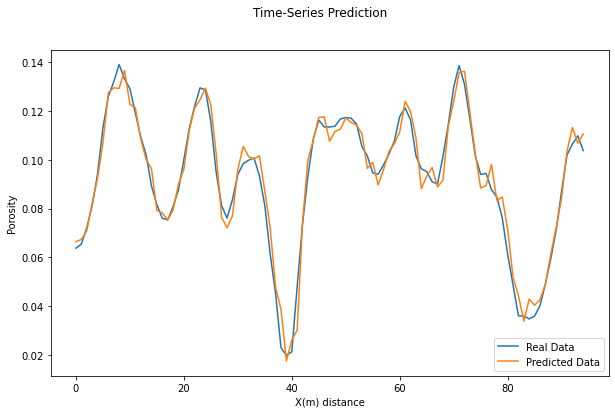

In [224]:
training_set = pd.read_csv('datasets/orig_sim3_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9826392333810021, pvalue=7.687053415926762e-70)
STD: 0.00523061
MSE: 2.7745364e-05


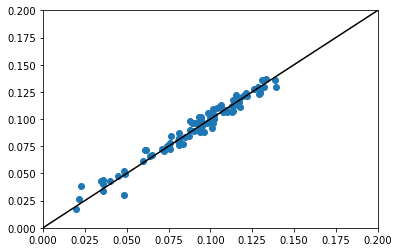

In [225]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.04574
Epoch: 100, loss: 0.00180
Epoch: 200, loss: 0.00162
Epoch: 300, loss: 0.00149
Epoch: 400, loss: 0.00147
Epoch: 500, loss: 0.00146
Epoch: 600, loss: 0.00146
Epoch: 700, loss: 0.00145
Epoch: 800, loss: 0.00144
Epoch: 900, loss: 0.00146
Epoch: 1000, loss: 0.00143
Epoch: 1100, loss: 0.00142
Epoch: 1200, loss: 0.00142
Epoch: 1300, loss: 0.00142
Epoch: 1400, loss: 0.00142
Epoch: 1500, loss: 0.00141
Epoch: 1600, loss: 0.00141
Epoch: 1700, loss: 0.00141
Epoch: 1800, loss: 0.00141
Epoch: 1900, loss: 0.00140


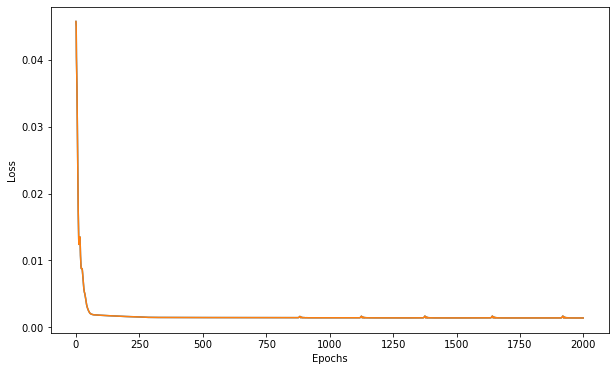

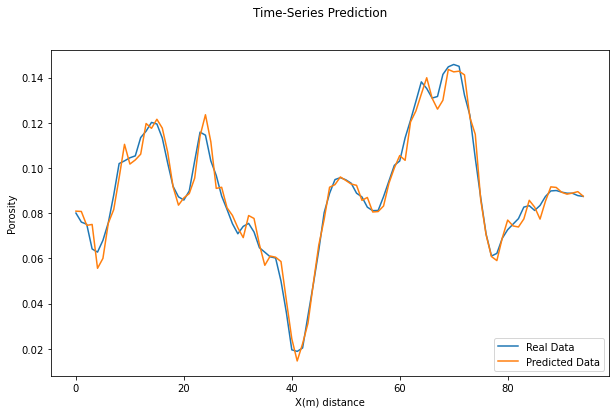

In [226]:
training_set = pd.read_csv('datasets/orig_sim3_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9863474477095956, pvalue=1.1732361148896334e-74)
STD: 0.004403385
MSE: 1.9402616e-05


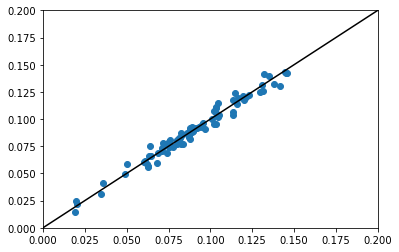

In [227]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new5 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse5 = mse(dataY_plot[:,0], data_predict[:,0])
real_d5 = dataY_plot[:,0]
pred_d5 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.9662999625995286
Average MSE:  9.106092038564384e-05


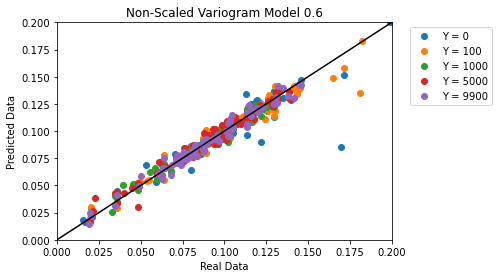

In [228]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 0')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 100')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 1000')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 5000')
plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Non-Scaled Variogram Model 0.6")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.legend(["0", "100", "5000", "9900"], loc ="upper left")
#print(new5[0])

In [229]:
con3 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4, pred_d5))
real3 = np.concatenate((real_d1, real_d2, real_d3, real_d4, real_d5))

## Variogram 0.8 Non-scaled

Epoch: 0, loss: 0.78507
Epoch: 100, loss: 0.00985
Epoch: 200, loss: 0.00548
Epoch: 300, loss: 0.00373
Epoch: 400, loss: 0.00304
Epoch: 500, loss: 0.00257
Epoch: 600, loss: 0.00223
Epoch: 700, loss: 0.00199
Epoch: 800, loss: 0.00179
Epoch: 900, loss: 0.00162
Epoch: 1000, loss: 0.00143
Epoch: 1100, loss: 0.00117
Epoch: 1200, loss: 0.00102
Epoch: 1300, loss: 0.00100
Epoch: 1400, loss: 0.00097
Epoch: 1500, loss: 0.00089
Epoch: 1600, loss: 0.00076
Epoch: 1700, loss: 0.00073
Epoch: 1800, loss: 0.00071
Epoch: 1900, loss: 0.00070


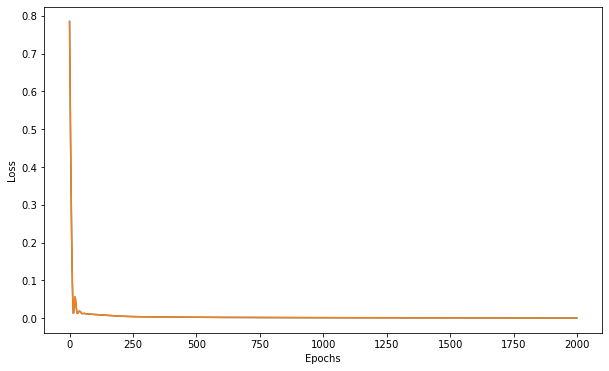

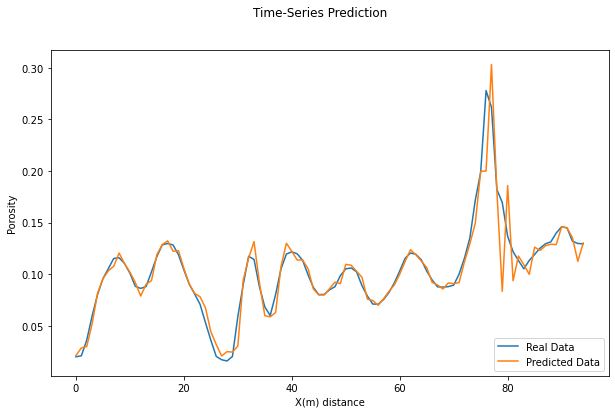

In [230]:
training_set = pd.read_csv('datasets/orig_sim4_0.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9317420423458035, pvalue=1.074747406396664e-42)
STD: 0.015416574
MSE: 0.0002396039


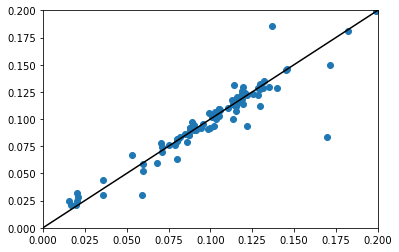

In [231]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.35081
Epoch: 100, loss: 0.01246
Epoch: 200, loss: 0.00401
Epoch: 300, loss: 0.00174
Epoch: 400, loss: 0.00124
Epoch: 500, loss: 0.00119
Epoch: 600, loss: 0.00113
Epoch: 700, loss: 0.00100
Epoch: 800, loss: 0.00078
Epoch: 900, loss: 0.00072
Epoch: 1000, loss: 0.00070
Epoch: 1100, loss: 0.00069
Epoch: 1200, loss: 0.00069
Epoch: 1300, loss: 0.00069
Epoch: 1400, loss: 0.00068
Epoch: 1500, loss: 0.00068
Epoch: 1600, loss: 0.00068
Epoch: 1700, loss: 0.00068
Epoch: 1800, loss: 0.00068
Epoch: 1900, loss: 0.00068


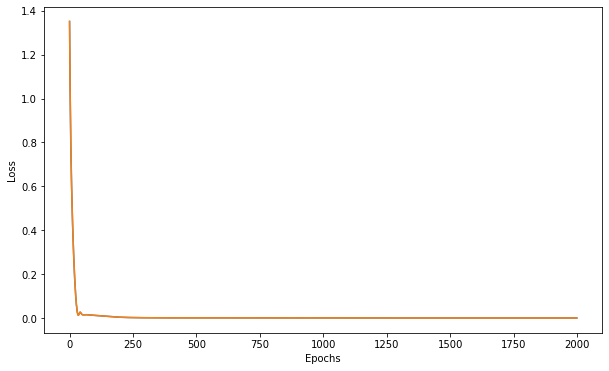

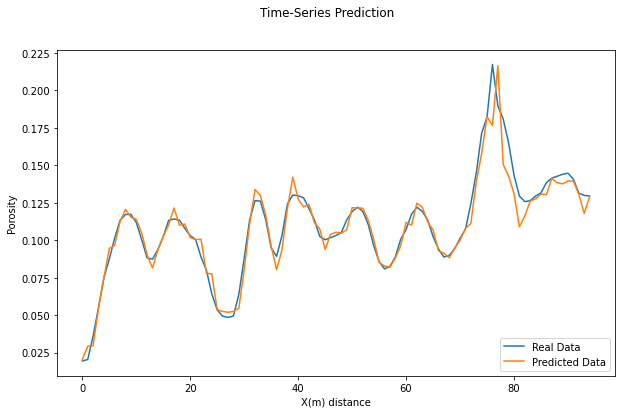

In [232]:
training_set = pd.read_csv('datasets/orig_sim4_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9685385938877171, pvalue=5.681837564715671e-58)
STD: 0.008280528
MSE: 7.106763e-05


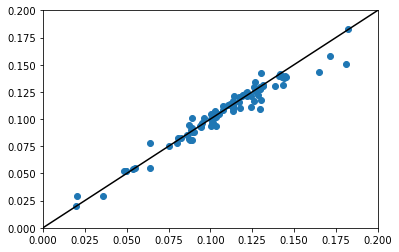

In [233]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.04569
Epoch: 100, loss: 0.00152
Epoch: 200, loss: 0.00146
Epoch: 300, loss: 0.00145
Epoch: 400, loss: 0.00143
Epoch: 500, loss: 0.00142
Epoch: 600, loss: 0.00141
Epoch: 700, loss: 0.00139
Epoch: 800, loss: 0.00136
Epoch: 900, loss: 0.00135
Epoch: 1000, loss: 0.00134
Epoch: 1100, loss: 0.00132
Epoch: 1200, loss: 0.00130
Epoch: 1300, loss: 0.00126
Epoch: 1400, loss: 0.00124
Epoch: 1500, loss: 0.00123
Epoch: 1600, loss: 0.00122
Epoch: 1700, loss: 0.00121
Epoch: 1800, loss: 0.00119
Epoch: 1900, loss: 0.00118


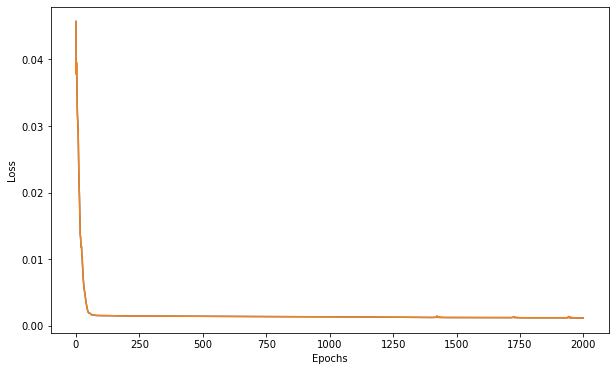

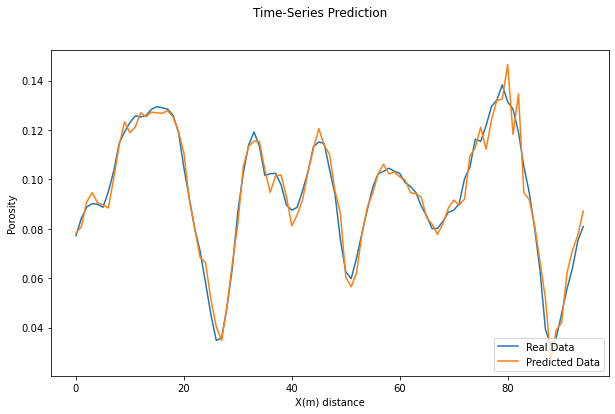

In [234]:
training_set = pd.read_csv('datasets/orig_sim4_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.981665206855282, pvalue=9.520033033788864e-69)
STD: 0.004811161
MSE: 2.320551e-05


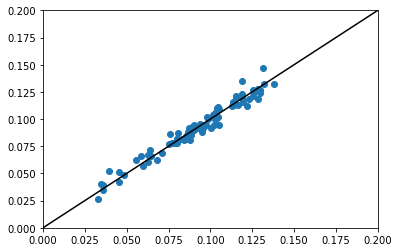

In [235]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.27107
Epoch: 100, loss: 0.02297
Epoch: 200, loss: 0.00936
Epoch: 300, loss: 0.00431
Epoch: 400, loss: 0.00318
Epoch: 500, loss: 0.00256
Epoch: 600, loss: 0.00205
Epoch: 700, loss: 0.00201
Epoch: 800, loss: 0.00198
Epoch: 900, loss: 0.00196
Epoch: 1000, loss: 0.00195
Epoch: 1100, loss: 0.00193
Epoch: 1200, loss: 0.00192
Epoch: 1300, loss: 0.00192
Epoch: 1400, loss: 0.00191
Epoch: 1500, loss: 0.00191
Epoch: 1600, loss: 0.00190
Epoch: 1700, loss: 0.00190
Epoch: 1800, loss: 0.00189
Epoch: 1900, loss: 0.00189


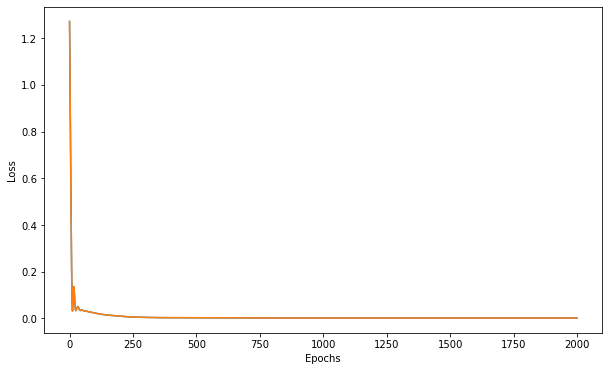

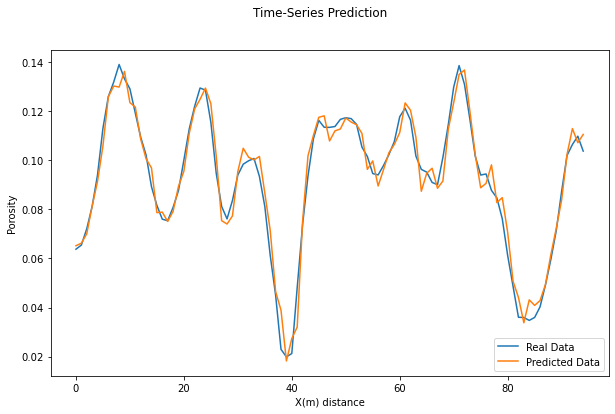

In [236]:
training_set = pd.read_csv('datasets/orig_sim4_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.982807839167231, pvalue=4.901366217979026e-70)
STD: 0.00520741
MSE: 2.7479271e-05


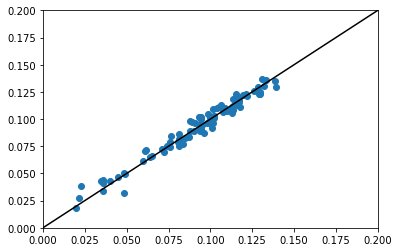

In [237]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.24160
Epoch: 100, loss: 0.02306
Epoch: 200, loss: 0.00657
Epoch: 300, loss: 0.00400
Epoch: 400, loss: 0.00371
Epoch: 500, loss: 0.00346
Epoch: 600, loss: 0.00323
Epoch: 700, loss: 0.00301
Epoch: 800, loss: 0.00277
Epoch: 900, loss: 0.00224
Epoch: 1000, loss: 0.00184
Epoch: 1100, loss: 0.00175
Epoch: 1200, loss: 0.00168
Epoch: 1300, loss: 0.00163
Epoch: 1400, loss: 0.00159
Epoch: 1500, loss: 0.00156
Epoch: 1600, loss: 0.00153
Epoch: 1700, loss: 0.00152
Epoch: 1800, loss: 0.00151
Epoch: 1900, loss: 0.00150


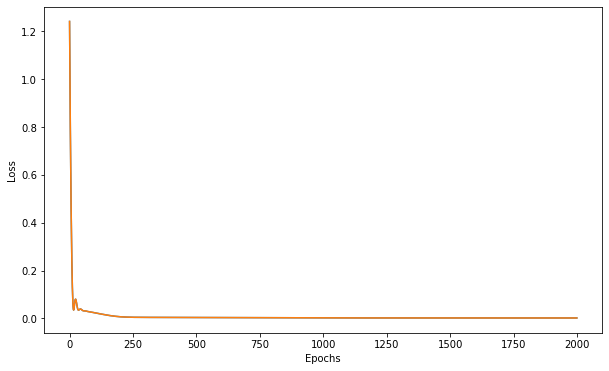

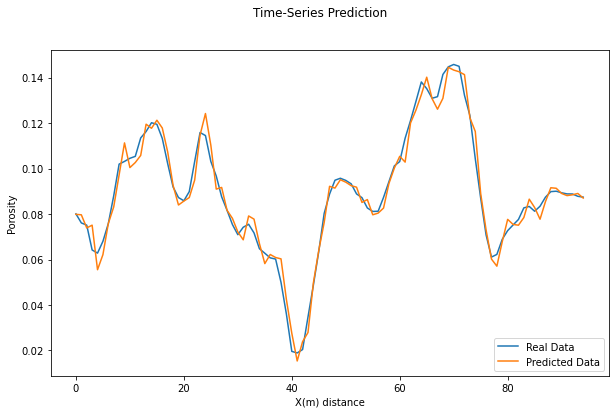

In [238]:
training_set = pd.read_csv('datasets/orig_sim4_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9853726360221225, pvalue=2.835767875766247e-73)
STD: 0.0045562955
MSE: 2.0764233e-05


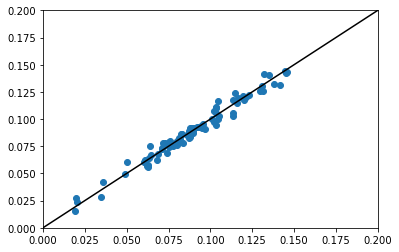

In [239]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new5 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse5 = mse(dataY_plot[:,0], data_predict[:,0])
real_d5 = dataY_plot[:,0]
pred_d5 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

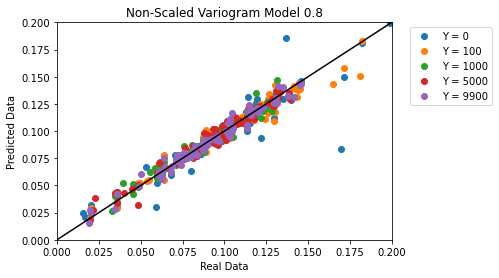

In [244]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 0')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 100')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 1000')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 5000')
plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')

plt.title("Non-Scaled Variogram Model 0.8")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [241]:
con4 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4, pred_d5))
real4 = np.concatenate((real_d1, real_d2, real_d3, real_d4, real_d5))

Average Pearson:  0.9700252636556312
Average MSE:  7.642411510460079e-05


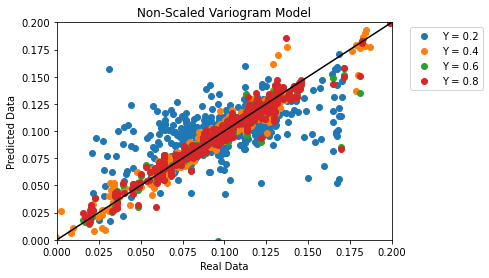

In [245]:
plt.plot(real1, con1, 'o', label = 'Y = 0.2')
plt.plot(real2, con2, 'o', label = 'Y = 0.4')
plt.plot(real3, con3, 'o', label = 'Y = 0.6')
plt.plot(real4, con4, 'o', label = 'Y = 0.8')
#plt.plot(real1, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
#pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
#mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
#print('Average Pearson: ', pearson_02_n)
#print('Average MSE: ', mse_02_n)
plt.title("Non-Scaled Variogram Model")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

## Scaling 50

In [246]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        #self.relu = nn.Sigmoid()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        #out = nn.functional.dropout(out, p=self.p, training=True)
        #out = self.relu(out) #relu
        
        return out

## Variogram 0.2 

Epoch: 0, loss: 1.49865
Epoch: 100, loss: 0.04510
Epoch: 200, loss: 0.04461
Epoch: 300, loss: 0.04417
Epoch: 400, loss: 0.04322
Epoch: 500, loss: 0.04259
Epoch: 600, loss: 0.04230
Epoch: 700, loss: 0.04172
Epoch: 800, loss: 0.03739
Epoch: 900, loss: 0.03342
Epoch: 1000, loss: 0.03020
Epoch: 1100, loss: 0.02658
Epoch: 1200, loss: 0.02002
Epoch: 1300, loss: 0.01117
Epoch: 1400, loss: 0.01096
Epoch: 1500, loss: 0.01093
Epoch: 1600, loss: 0.01086
Epoch: 1700, loss: 0.01043
Epoch: 1800, loss: 0.01028
Epoch: 1900, loss: 0.00970


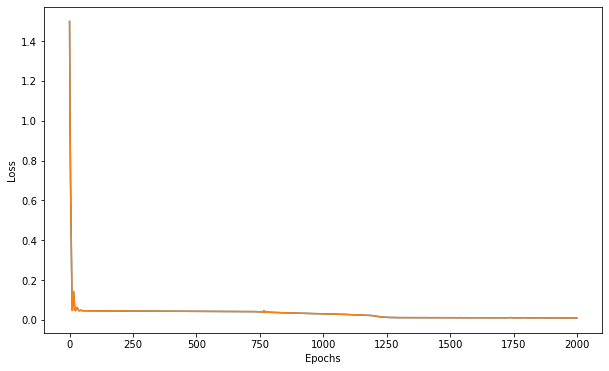

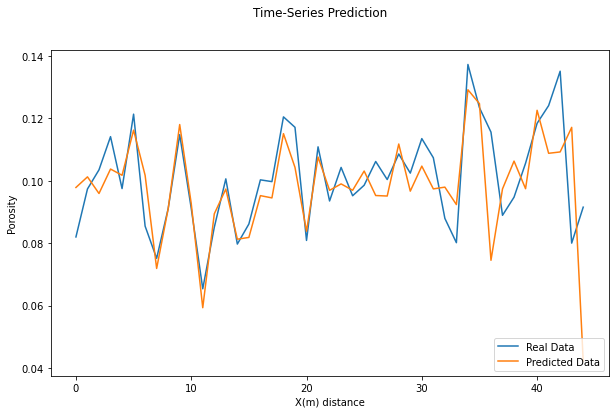

In [247]:
training_set = pd.read_csv('datasets/scaled_v1_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.6349193989689574, pvalue=2.8065999418578716e-06)
STD: 0.013565075
MSE: 0.00019044572


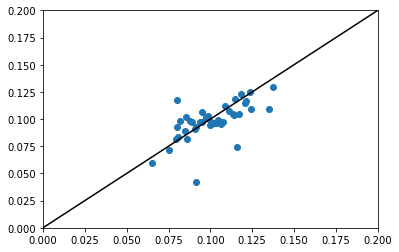

In [248]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.02987
Epoch: 100, loss: 0.02836
Epoch: 200, loss: 0.02610
Epoch: 300, loss: 0.01167
Epoch: 400, loss: 0.00819
Epoch: 500, loss: 0.00760
Epoch: 600, loss: 0.00721
Epoch: 700, loss: 0.00681
Epoch: 800, loss: 0.00693
Epoch: 900, loss: 0.00490
Epoch: 1000, loss: 0.00416
Epoch: 1100, loss: 0.00521
Epoch: 1200, loss: 0.00355
Epoch: 1300, loss: 0.00335
Epoch: 1400, loss: 0.00312
Epoch: 1500, loss: 0.00312
Epoch: 1600, loss: 0.00293
Epoch: 1700, loss: 0.00310
Epoch: 1800, loss: 0.00289
Epoch: 1900, loss: 0.02407


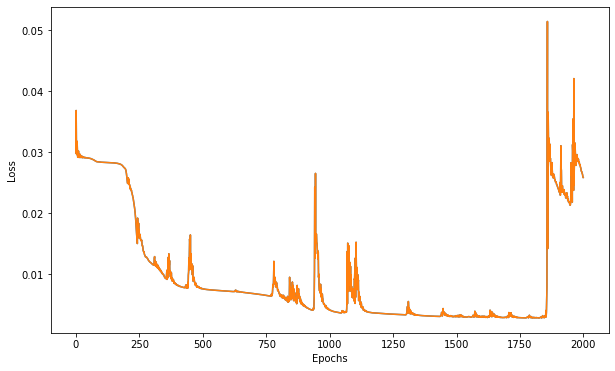

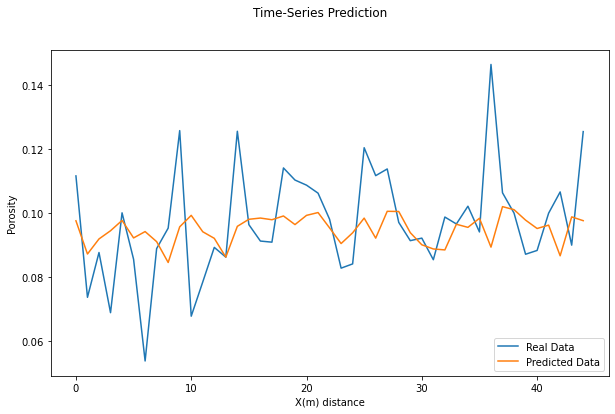

In [250]:
training_set = pd.read_csv('datasets/scaled_v1_50_115.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.18940522058882858, pvalue=0.21271628405593032)
STD: 0.016596535
MSE: 0.00028076678


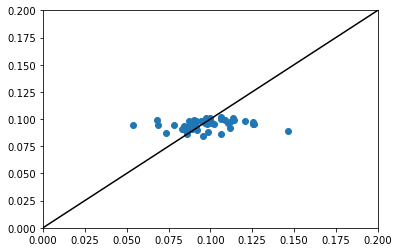

In [251]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.24392
Epoch: 100, loss: 0.05589
Epoch: 200, loss: 0.05582
Epoch: 300, loss: 0.03272
Epoch: 400, loss: 0.02200
Epoch: 500, loss: 0.01751
Epoch: 600, loss: 0.01504
Epoch: 700, loss: 0.01378
Epoch: 800, loss: 0.01762
Epoch: 900, loss: 0.01006
Epoch: 1000, loss: 0.00705
Epoch: 1100, loss: 0.00600
Epoch: 1200, loss: 0.00580
Epoch: 1300, loss: 0.00526
Epoch: 1400, loss: 0.00428
Epoch: 1500, loss: 0.00425
Epoch: 1600, loss: 0.03227
Epoch: 1700, loss: 0.02518
Epoch: 1800, loss: 0.01849
Epoch: 1900, loss: 0.01489


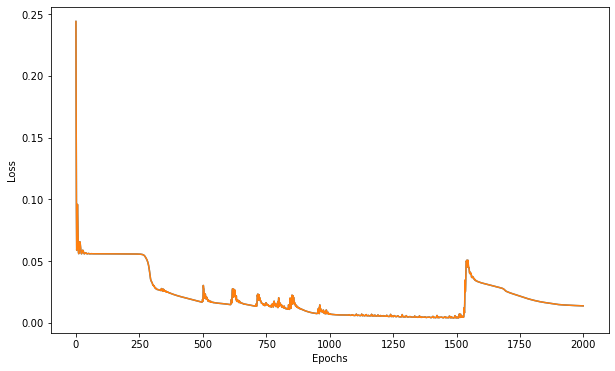

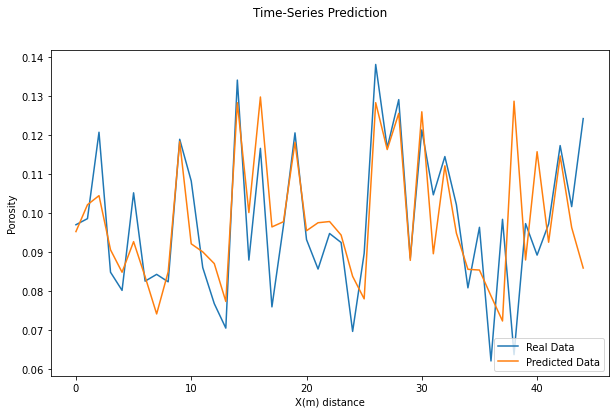

In [252]:
training_set = pd.read_csv('datasets/scaled_v1_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.6206604180576525, pvalue=5.407973667616358e-06)
STD: 0.015180025
MSE: 0.0002306883


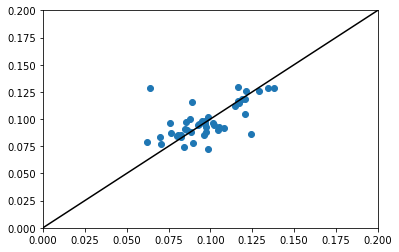

In [253]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.05523
Epoch: 100, loss: 0.03220
Epoch: 200, loss: 0.03220
Epoch: 300, loss: 0.03218
Epoch: 400, loss: 0.03210
Epoch: 500, loss: 0.03022
Epoch: 600, loss: 0.02155
Epoch: 700, loss: 0.02005
Epoch: 800, loss: 0.02663
Epoch: 900, loss: 0.01931
Epoch: 1000, loss: 0.01879
Epoch: 1100, loss: 0.01771
Epoch: 1200, loss: 0.01729
Epoch: 1300, loss: 0.01686
Epoch: 1400, loss: 0.01678
Epoch: 1500, loss: 0.01653
Epoch: 1600, loss: 0.01643
Epoch: 1700, loss: 0.01635
Epoch: 1800, loss: 0.01626
Epoch: 1900, loss: 0.01618


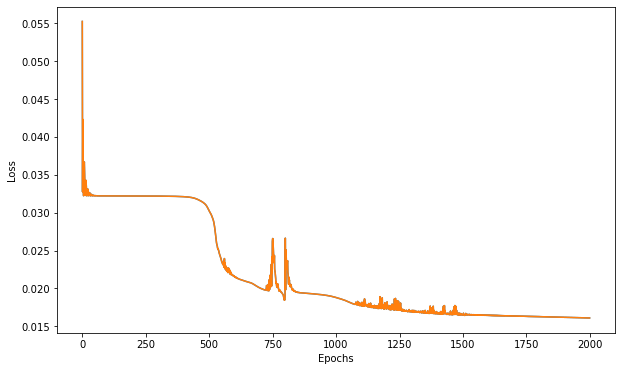

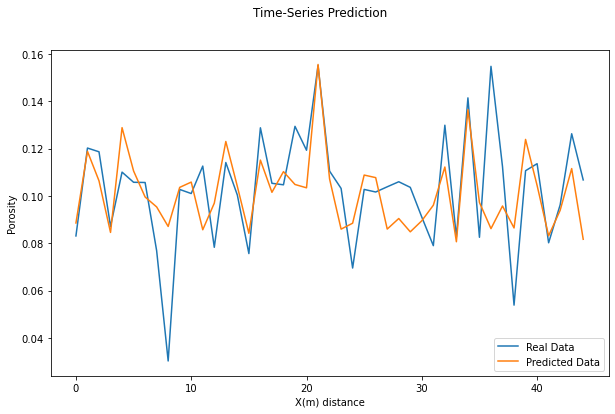

In [254]:
training_set = pd.read_csv('datasets/scaled_v1_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.5939161725811078, pvalue=1.701973188575603e-05)
STD: 0.018919453
MSE: 0.00036072877


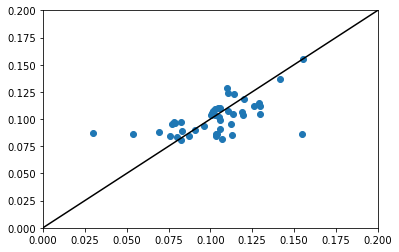

In [255]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.5097253025491366
Average MSE:  0.0002656573778949678


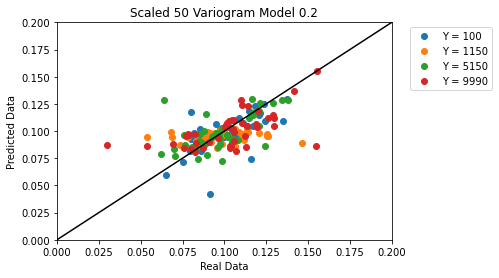

In [256]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 100')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 1150')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 5150')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0]) / 4
mse_02_n = (mse1 + mse2 + mse3 + mse4) / 4
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 50 Variogram Model 0.2")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [257]:
con1 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4))
real1 = np.concatenate((real_d1, real_d2, real_d3, real_d4))

## Variogram 0.4 Scaled 50

Epoch: 0, loss: 0.13590
Epoch: 100, loss: 0.00858
Epoch: 200, loss: 0.00671
Epoch: 300, loss: 0.00595
Epoch: 400, loss: 0.00550
Epoch: 500, loss: 0.00535
Epoch: 600, loss: 0.00528
Epoch: 700, loss: 0.00524
Epoch: 800, loss: 0.00523
Epoch: 900, loss: 0.00520
Epoch: 1000, loss: 0.00518
Epoch: 1100, loss: 0.00519
Epoch: 1200, loss: 0.00515
Epoch: 1300, loss: 0.00481
Epoch: 1400, loss: 0.00374
Epoch: 1500, loss: 0.00374
Epoch: 1600, loss: 0.00335
Epoch: 1700, loss: 0.00415
Epoch: 1800, loss: 0.00324
Epoch: 1900, loss: 0.00307


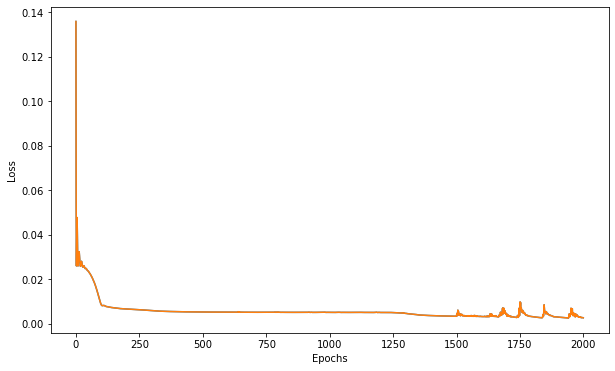

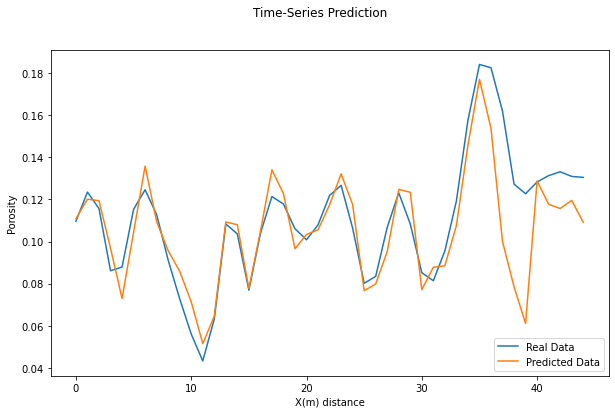

In [258]:
training_set = pd.read_csv('datasets/scaled_v2_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8045406529486261, pvalue=2.7644868833654978e-11)
STD: 0.017040886
MSE: 0.00031908712


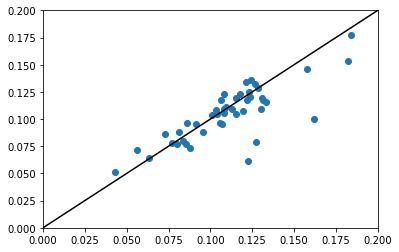

In [259]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.06775
Epoch: 100, loss: 0.00601
Epoch: 200, loss: 0.00546
Epoch: 300, loss: 0.00448
Epoch: 400, loss: 0.00379
Epoch: 500, loss: 0.00335
Epoch: 600, loss: 0.00321
Epoch: 700, loss: 0.00294
Epoch: 800, loss: 0.00282
Epoch: 900, loss: 0.00279
Epoch: 1000, loss: 0.00254
Epoch: 1100, loss: 0.00248
Epoch: 1200, loss: 0.00243
Epoch: 1300, loss: 0.00244
Epoch: 1400, loss: 0.00229
Epoch: 1500, loss: 0.00254
Epoch: 1600, loss: 0.00220
Epoch: 1700, loss: 0.00225
Epoch: 1800, loss: 0.00212
Epoch: 1900, loss: 0.00209


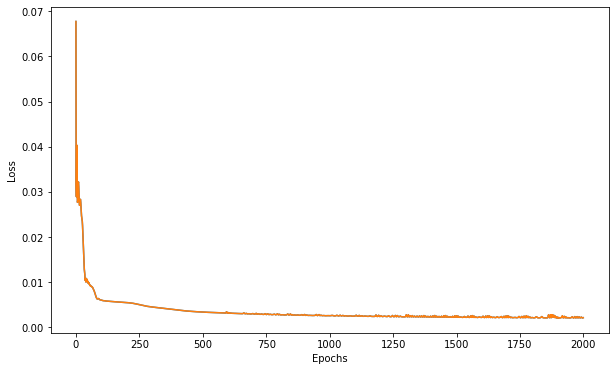

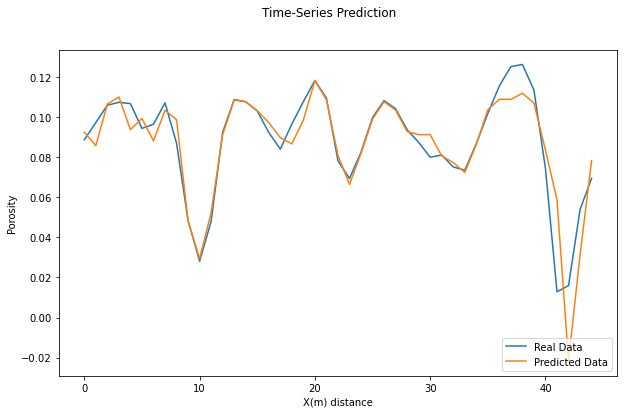

In [260]:
training_set = pd.read_csv('datasets/scaled_v2_50_115.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9054822564167256, pvalue=1.3102303966380515e-17)
STD: 0.011248213
MSE: 0.00012750238


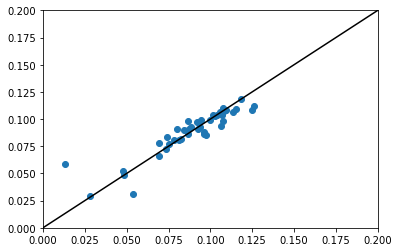

In [261]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.35748
Epoch: 100, loss: 0.03254
Epoch: 200, loss: 0.01368
Epoch: 300, loss: 0.00830
Epoch: 400, loss: 0.00754
Epoch: 500, loss: 0.00746
Epoch: 600, loss: 0.00739
Epoch: 700, loss: 0.00732
Epoch: 800, loss: 0.00726
Epoch: 900, loss: 0.00719
Epoch: 1000, loss: 0.00713
Epoch: 1100, loss: 0.00705
Epoch: 1200, loss: 0.00694
Epoch: 1300, loss: 0.00640
Epoch: 1400, loss: 0.00571
Epoch: 1500, loss: 0.00546
Epoch: 1600, loss: 0.00525
Epoch: 1700, loss: 0.00512
Epoch: 1800, loss: 0.00579
Epoch: 1900, loss: 0.00490


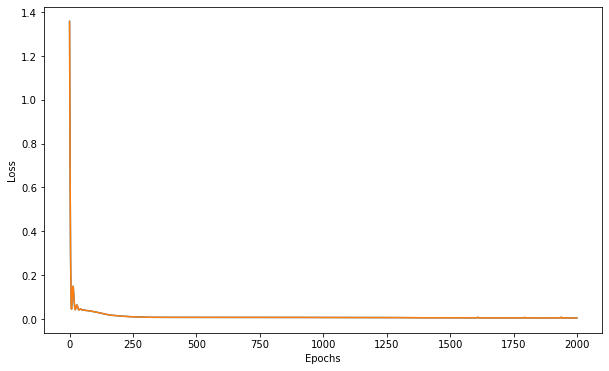

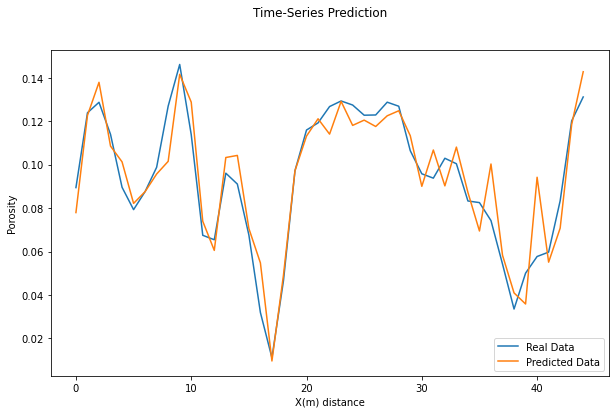

In [262]:
training_set = pd.read_csv('datasets/scaled_v2_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9330633873899691, pvalue=1.0408973787250565e-20)
STD: 0.011214927
MSE: 0.00012699954


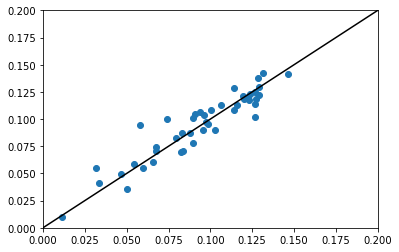

In [263]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.04643
Epoch: 100, loss: 0.00712
Epoch: 200, loss: 0.00578
Epoch: 300, loss: 0.00558
Epoch: 400, loss: 0.00544
Epoch: 500, loss: 0.00529
Epoch: 600, loss: 0.00511
Epoch: 700, loss: 0.00488
Epoch: 800, loss: 0.00557
Epoch: 900, loss: 0.00437
Epoch: 1000, loss: 0.00409
Epoch: 1100, loss: 0.00372
Epoch: 1200, loss: 0.00343
Epoch: 1300, loss: 0.00328
Epoch: 1400, loss: 0.00326
Epoch: 1500, loss: 0.00305
Epoch: 1600, loss: 0.00299
Epoch: 1700, loss: 0.00287
Epoch: 1800, loss: 0.00283
Epoch: 1900, loss: 0.00280


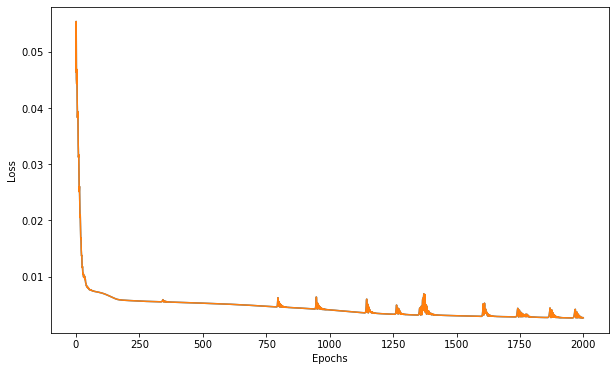

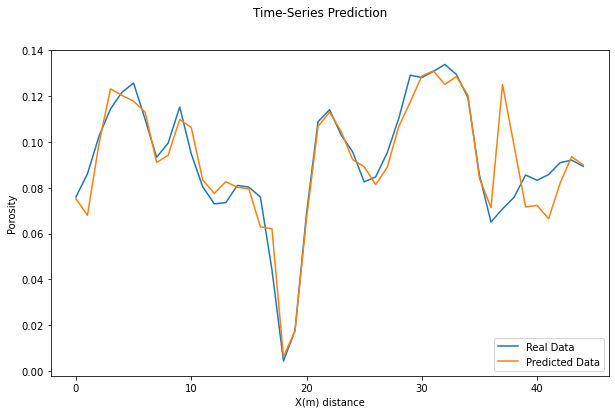

In [264]:
training_set = pd.read_csv('datasets/scaled_v2_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.907420592369351, pvalue=8.560206208868952e-18)
STD: 0.0114488
MSE: 0.00013107622


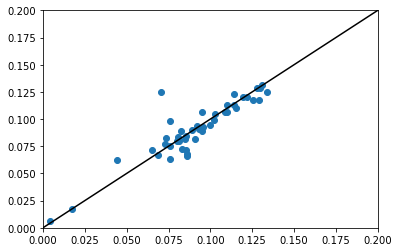

In [265]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.887626722281168
Average MSE:  0.0001761663006618619


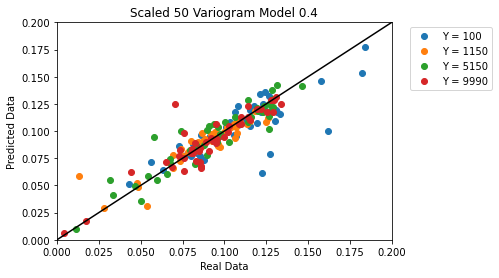

In [266]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 100')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 1150')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 5150')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0]) / 4
mse_02_n = (mse1 + mse2 + mse3 + mse4) / 4
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 50 Variogram Model 0.4")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [267]:
con2 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4))
real2 = np.concatenate((real_d1, real_d2, real_d3, real_d4))

## Variogram 0.6 Scaled 50 

Epoch: 0, loss: 0.02017
Epoch: 100, loss: 0.00404
Epoch: 200, loss: 0.00361
Epoch: 300, loss: 0.00335
Epoch: 400, loss: 0.00305
Epoch: 500, loss: 0.00281
Epoch: 600, loss: 0.00207
Epoch: 700, loss: 0.00183
Epoch: 800, loss: 0.00185
Epoch: 900, loss: 0.00191
Epoch: 1000, loss: 0.00169
Epoch: 1100, loss: 0.00162
Epoch: 1200, loss: 0.00152
Epoch: 1300, loss: 0.00171
Epoch: 1400, loss: 0.00144
Epoch: 1500, loss: 0.00138
Epoch: 1600, loss: 0.00137
Epoch: 1700, loss: 0.00134
Epoch: 1800, loss: 0.00130
Epoch: 1900, loss: 0.00146


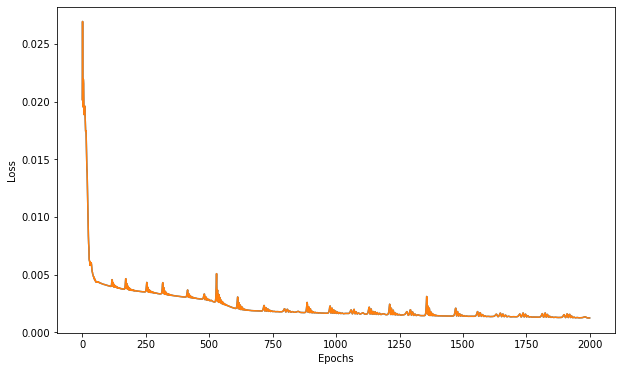

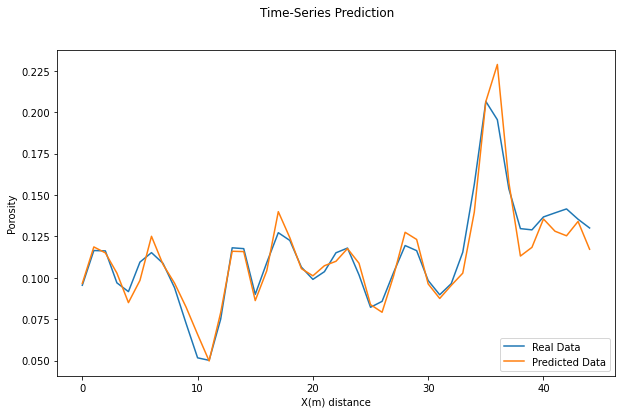

In [268]:
training_set = pd.read_csv('datasets/scaled_v3_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9563100495569151, pvalue=1.3655211166848153e-24)
STD: 0.008946664
MSE: 8.027762e-05


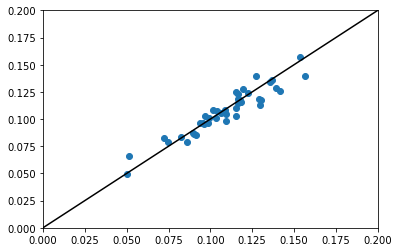

In [269]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.15446
Epoch: 100, loss: 0.02901
Epoch: 200, loss: 0.01560
Epoch: 300, loss: 0.01058
Epoch: 400, loss: 0.00839
Epoch: 500, loss: 0.00716
Epoch: 600, loss: 0.00691
Epoch: 700, loss: 0.00683
Epoch: 800, loss: 0.00678
Epoch: 900, loss: 0.00670
Epoch: 1000, loss: 0.00659
Epoch: 1100, loss: 0.00644
Epoch: 1200, loss: 0.00623
Epoch: 1300, loss: 0.00596
Epoch: 1400, loss: 0.00562
Epoch: 1500, loss: 0.00525
Epoch: 1600, loss: 0.00501
Epoch: 1700, loss: 0.00487
Epoch: 1800, loss: 0.00477
Epoch: 1900, loss: 0.00466


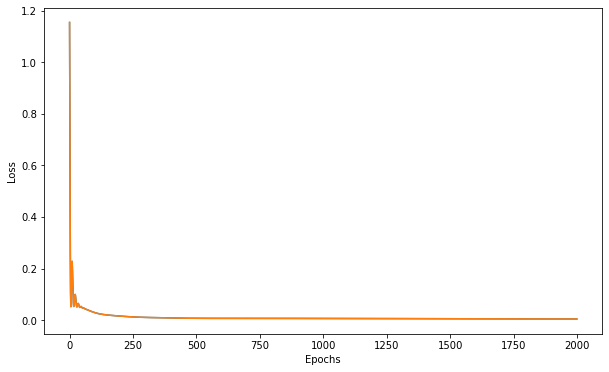

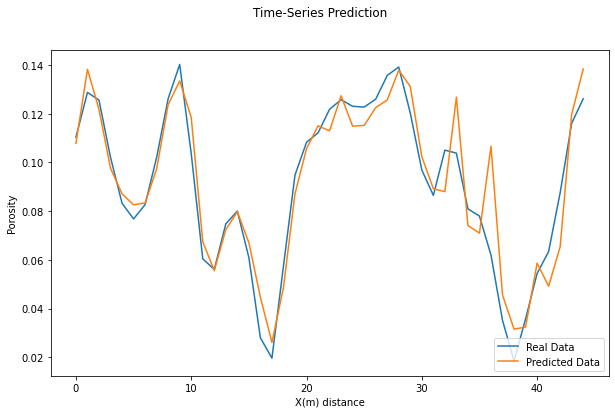

In [270]:
training_set = pd.read_csv('datasets/scaled_v3_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9424247141522759, pvalue=4.4843919947417e-22)
STD: 0.011101442
MSE: 0.00012442122


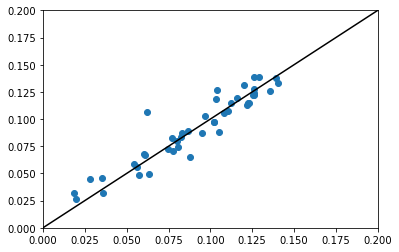

In [271]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.07609
Epoch: 100, loss: 0.00707
Epoch: 200, loss: 0.00620
Epoch: 300, loss: 0.00575
Epoch: 400, loss: 0.00522
Epoch: 500, loss: 0.00379
Epoch: 600, loss: 0.00321
Epoch: 700, loss: 0.00306
Epoch: 800, loss: 0.00303
Epoch: 900, loss: 0.00288
Epoch: 1000, loss: 0.00280
Epoch: 1100, loss: 0.00274
Epoch: 1200, loss: 0.00266
Epoch: 1300, loss: 0.00254
Epoch: 1400, loss: 0.00245
Epoch: 1500, loss: 0.00235
Epoch: 1600, loss: 0.00218
Epoch: 1700, loss: 0.00208
Epoch: 1800, loss: 0.00196
Epoch: 1900, loss: 0.00190


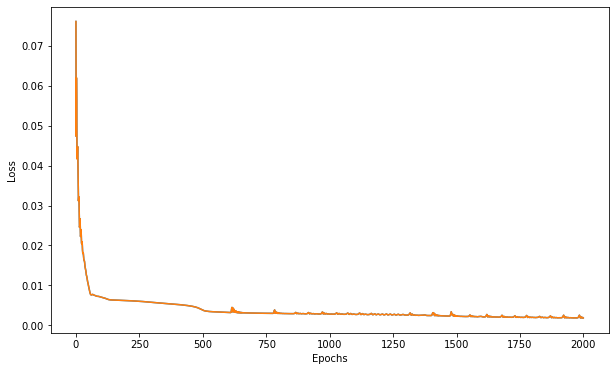

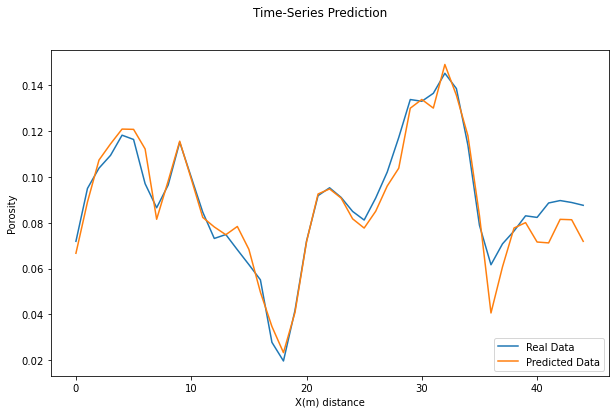

In [272]:
training_set = pd.read_csv('datasets/scaled_v3_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9669339662855062, pvalue=3.800238755735256e-27)
STD: 0.007037075
MSE: 5.309936e-05


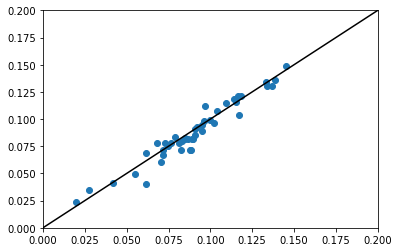

In [273]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.9496830293461667
Average MSE:  9.619943739380687e-05


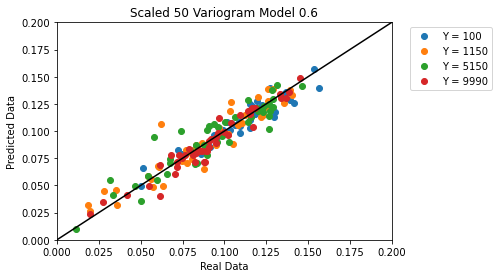

In [274]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 100')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 1150')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 5150')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0]) / 4
mse_02_n = (mse1 + mse2 + mse3 + mse4) / 4
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 50 Variogram Model 0.6")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [275]:
con3 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4))
real3 = np.concatenate((real_d1, real_d2, real_d3, real_d4))

## Variogram 0.8 Scale 50

Epoch: 0, loss: 0.12349
Epoch: 100, loss: 0.00637
Epoch: 200, loss: 0.00402
Epoch: 300, loss: 0.00381
Epoch: 400, loss: 0.00368
Epoch: 500, loss: 0.00355
Epoch: 600, loss: 0.00340
Epoch: 700, loss: 0.00328
Epoch: 800, loss: 0.00320
Epoch: 900, loss: 0.00313
Epoch: 1000, loss: 0.00308
Epoch: 1100, loss: 0.00302
Epoch: 1200, loss: 0.00295
Epoch: 1300, loss: 0.00286
Epoch: 1400, loss: 0.00271
Epoch: 1500, loss: 0.00230
Epoch: 1600, loss: 0.00173
Epoch: 1700, loss: 0.00145
Epoch: 1800, loss: 0.00140
Epoch: 1900, loss: 0.00137


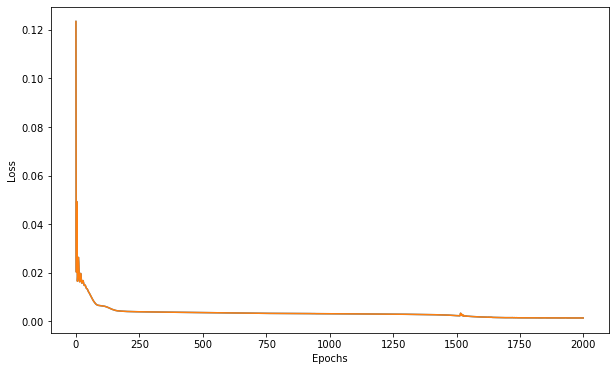

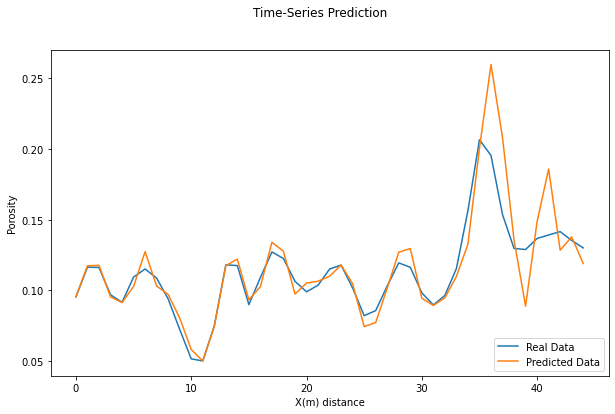

In [276]:
training_set = pd.read_csv('datasets/scaled_v4_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9047708173156729, pvalue=1.5282814952901325e-17)
STD: 0.016837265
MSE: 0.0002897978


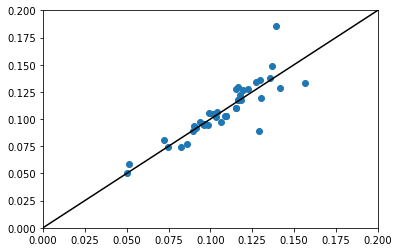

In [277]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.39970
Epoch: 100, loss: 0.02273
Epoch: 200, loss: 0.00947
Epoch: 300, loss: 0.00744
Epoch: 400, loss: 0.00718
Epoch: 500, loss: 0.00692
Epoch: 600, loss: 0.00668
Epoch: 700, loss: 0.00637
Epoch: 800, loss: 0.00616
Epoch: 900, loss: 0.00603
Epoch: 1000, loss: 0.00568
Epoch: 1100, loss: 0.00531
Epoch: 1200, loss: 0.00512
Epoch: 1300, loss: 0.01110
Epoch: 1400, loss: 0.00489
Epoch: 1500, loss: 0.00431
Epoch: 1600, loss: 0.00426
Epoch: 1700, loss: 0.00401
Epoch: 1800, loss: 0.00379
Epoch: 1900, loss: 0.00452


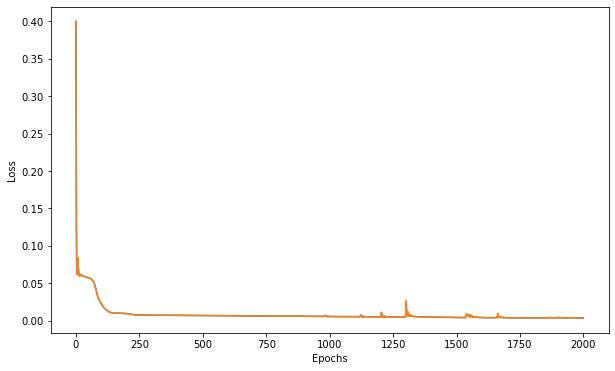

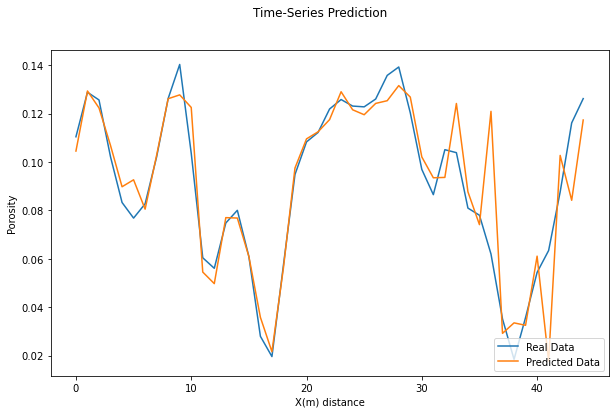

In [278]:
training_set = pd.read_csv('datasets/scaled_v4_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9078943605664882, pvalue=7.703403688427706e-18)
STD: 0.014270158
MSE: 0.0002040095


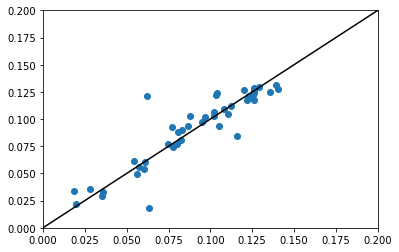

In [279]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.64254
Epoch: 100, loss: 0.01678
Epoch: 200, loss: 0.00676
Epoch: 300, loss: 0.00617
Epoch: 400, loss: 0.00540
Epoch: 500, loss: 0.00498
Epoch: 600, loss: 0.00467
Epoch: 700, loss: 0.00419
Epoch: 800, loss: 0.00350
Epoch: 900, loss: 0.00284
Epoch: 1000, loss: 0.00243
Epoch: 1100, loss: 0.00219
Epoch: 1200, loss: 0.00202
Epoch: 1300, loss: 0.00194
Epoch: 1400, loss: 0.00190
Epoch: 1500, loss: 0.00187
Epoch: 1600, loss: 0.00193
Epoch: 1700, loss: 0.00188
Epoch: 1800, loss: 0.00181
Epoch: 1900, loss: 0.00179


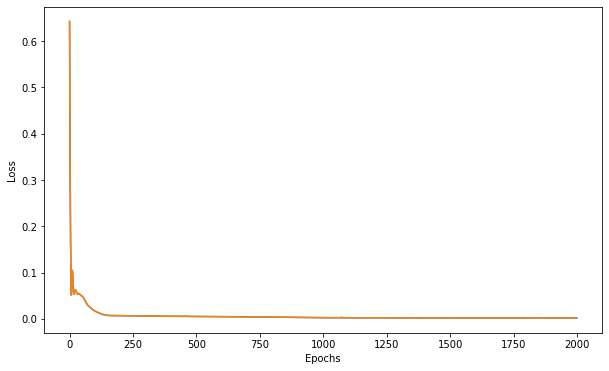

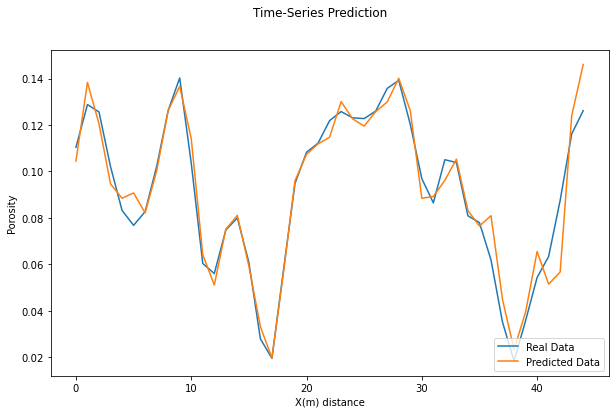

In [280]:
training_set = pd.read_csv('datasets/scaled_v4_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9685893436433266, pvalue=1.2805559042941664e-27)
STD: 0.008287783
MSE: 6.9226524e-05


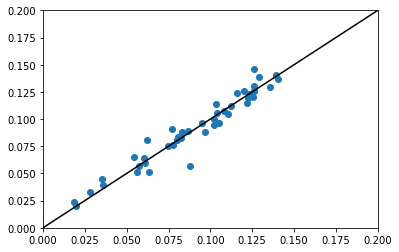

In [281]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.44104
Epoch: 100, loss: 0.00750
Epoch: 200, loss: 0.00664
Epoch: 300, loss: 0.00610
Epoch: 400, loss: 0.00600
Epoch: 500, loss: 0.00589
Epoch: 600, loss: 0.00576
Epoch: 700, loss: 0.00562
Epoch: 800, loss: 0.00549
Epoch: 900, loss: 0.00537
Epoch: 1000, loss: 0.00526
Epoch: 1100, loss: 0.00515
Epoch: 1200, loss: 0.00501
Epoch: 1300, loss: 0.00484
Epoch: 1400, loss: 0.00467
Epoch: 1500, loss: 0.00459
Epoch: 1600, loss: 0.00441
Epoch: 1700, loss: 0.00430
Epoch: 1800, loss: 0.00416
Epoch: 1900, loss: 0.00400


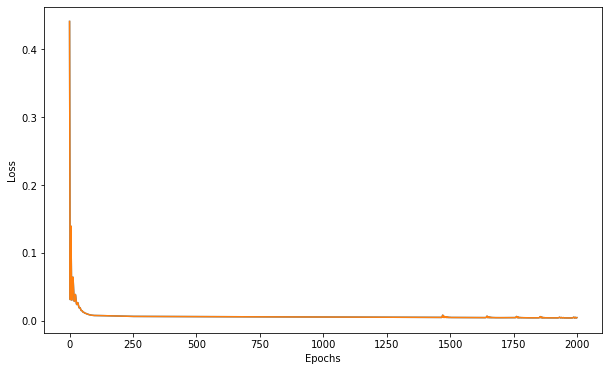

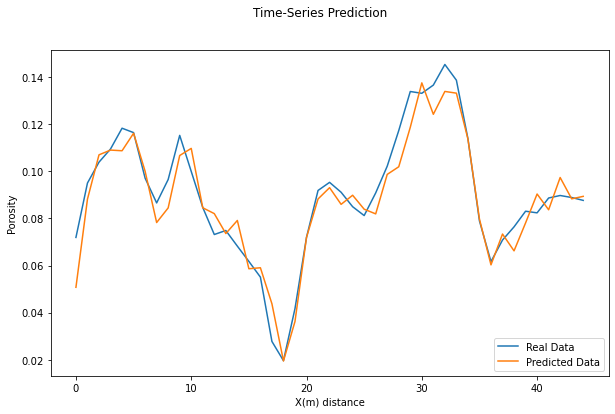

In [282]:
training_set = pd.read_csv('datasets/scaled_v4_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9603072744358024, pvalue=1.805985386608696e-25)
STD: 0.0075304518
MSE: 6.113798e-05


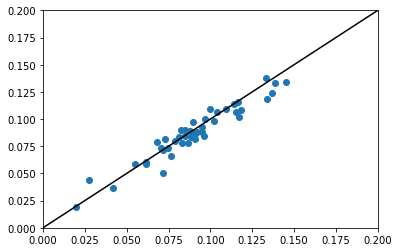

In [283]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.9353904489903224
Average MSE:  0.00015604295185767114


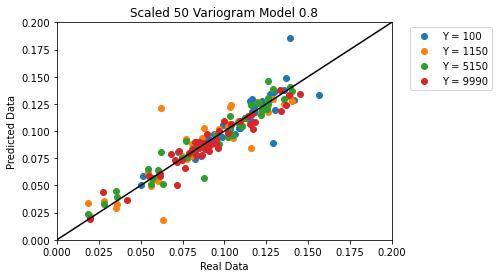

In [284]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 100')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 1150')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 5150')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0]) / 4
mse_02_n = (mse1 + mse2 + mse3 + mse4) / 4
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 50 Variogram Model 0.8")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [285]:
con4 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4))
real4 = np.concatenate((real_d1, real_d2, real_d3, real_d4))

### Total Scaled 50 Variogram

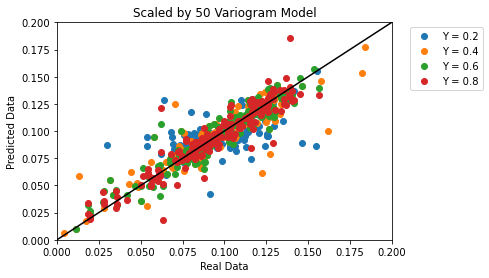

In [286]:
plt.plot(real1, con1, 'o', label = 'Y = 0.2')
plt.plot(real2, con2, 'o', label = 'Y = 0.4')
plt.plot(real3, con3, 'o', label = 'Y = 0.6')
plt.plot(real4, con4, 'o', label = 'Y = 0.8')
#plt.plot(real1, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
#pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
#mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
#print('Average Pearson: ', pearson_02_n)
#print('Average MSE: ', mse_02_n)
plt.title("Scaled by 50 Variogram Model")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

## Scaled 20

In [287]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        #self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        
        return out

Epoch: 0, loss: 0.14255
Epoch: 100, loss: 0.01403
Epoch: 200, loss: 0.00014
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00004
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00002
Epoch: 1400, loss: 0.00000
Epoch: 1500, loss: 0.00000
Epoch: 1600, loss: 0.00000
Epoch: 1700, loss: 0.00000
Epoch: 1800, loss: 0.00000
Epoch: 1900, loss: 0.00000


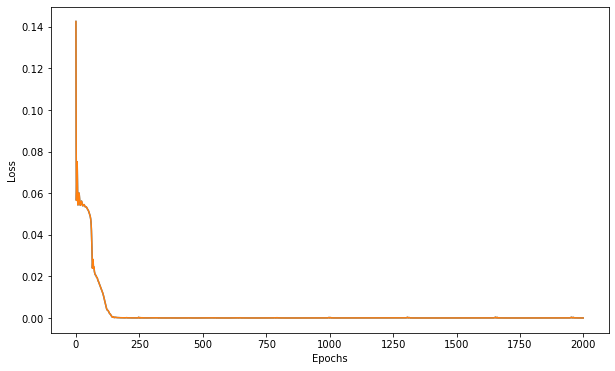

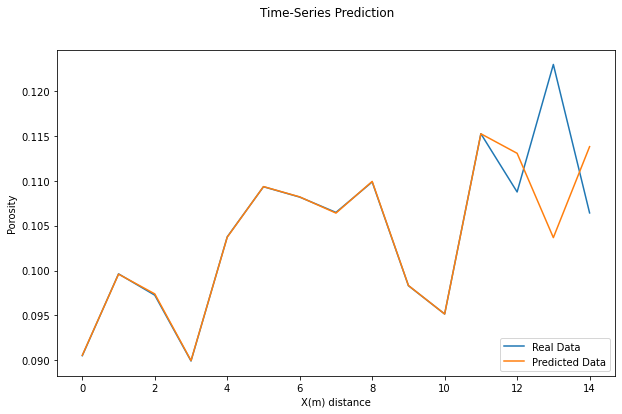

In [288]:
training_set = pd.read_csv('datasets/scaled_v1_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.07

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2


lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7935681208613063, pvalue=0.0004135110482836711)
STD: 0.005424849
MSE: 2.9672881e-05


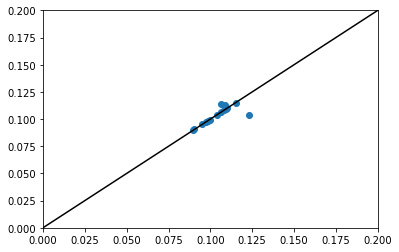

In [289]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.95543
Epoch: 100, loss: 0.03425
Epoch: 200, loss: 0.03363
Epoch: 300, loss: 0.03319
Epoch: 400, loss: 0.03265
Epoch: 500, loss: 0.03196
Epoch: 600, loss: 0.03114
Epoch: 700, loss: 0.03027
Epoch: 800, loss: 0.02948
Epoch: 900, loss: 0.02884
Epoch: 1000, loss: 0.02836
Epoch: 1100, loss: 0.02800
Epoch: 1200, loss: 0.02774
Epoch: 1300, loss: 0.02754
Epoch: 1400, loss: 0.02739
Epoch: 1500, loss: 0.02727
Epoch: 1600, loss: 0.02716
Epoch: 1700, loss: 0.02612
Epoch: 1800, loss: 0.01383
Epoch: 1900, loss: 0.01147


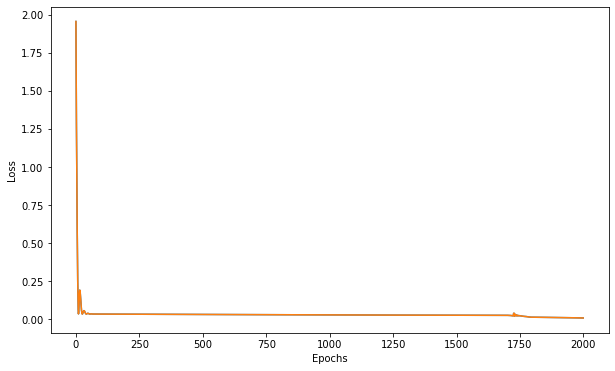

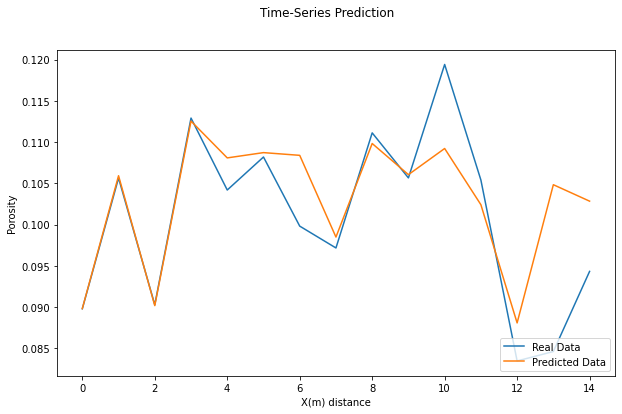

In [290]:
training_set = pd.read_csv('datasets/scaled_v1_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.07

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2


lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7753680141551798, pvalue=0.0006830030454520189)
STD: 0.0065020346
MSE: 4.7247573e-05


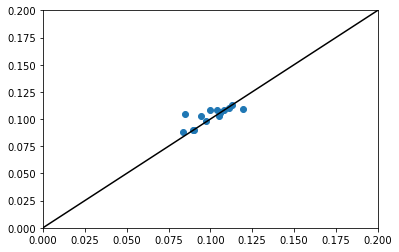

In [291]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.17244
Epoch: 100, loss: 0.08833
Epoch: 200, loss: 0.00929
Epoch: 300, loss: 0.00222
Epoch: 400, loss: 0.00127
Epoch: 500, loss: 0.00101
Epoch: 600, loss: 0.00085
Epoch: 700, loss: 0.00074
Epoch: 800, loss: 0.00066
Epoch: 900, loss: 0.00059
Epoch: 1000, loss: 0.00103
Epoch: 1100, loss: 0.00050
Epoch: 1200, loss: 0.00047
Epoch: 1300, loss: 0.00068
Epoch: 1400, loss: 0.00079
Epoch: 1500, loss: 0.00040
Epoch: 1600, loss: 0.00039
Epoch: 1700, loss: 0.00038
Epoch: 1800, loss: 0.00041
Epoch: 1900, loss: 0.00034


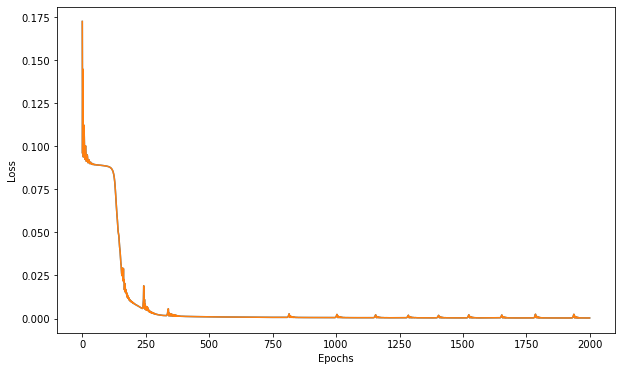

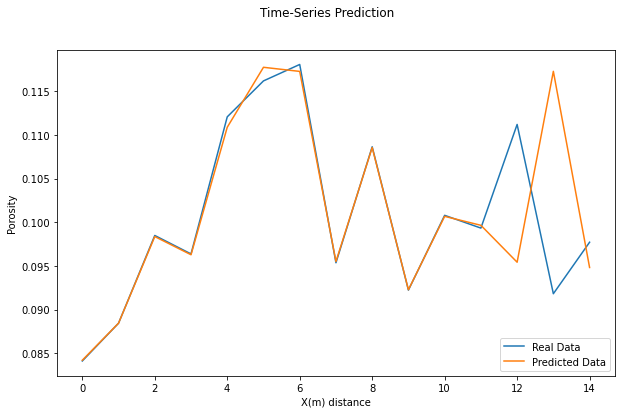

In [292]:
training_set = pd.read_csv('datasets/scaled_v1_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.07

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7072867000208694, pvalue=0.0031865263373903278)
STD: 0.007782324
MSE: 6.0755057e-05


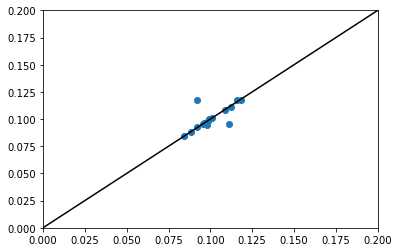

In [293]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.7587409450124518
Average MSE:  4.589183663483709e-05


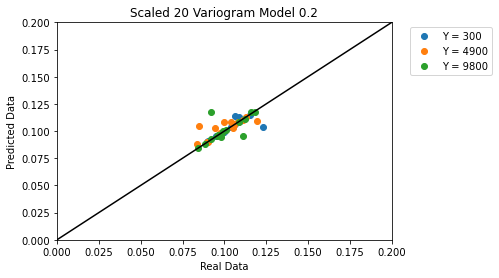

In [294]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 20 Variogram Model 0.2")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [295]:
con1 = np.concatenate((pred_d1, pred_d2, pred_d3))
real1 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.4 Scale 10

Epoch: 0, loss: 0.71397
Epoch: 100, loss: 0.03086
Epoch: 200, loss: 0.03082
Epoch: 300, loss: 0.03080
Epoch: 400, loss: 0.03078
Epoch: 500, loss: 0.03077
Epoch: 600, loss: 0.03076
Epoch: 700, loss: 0.03075
Epoch: 800, loss: 0.03073
Epoch: 900, loss: 0.03069
Epoch: 1000, loss: 0.03055
Epoch: 1100, loss: 0.02866
Epoch: 1200, loss: 0.02568
Epoch: 1300, loss: 0.02523


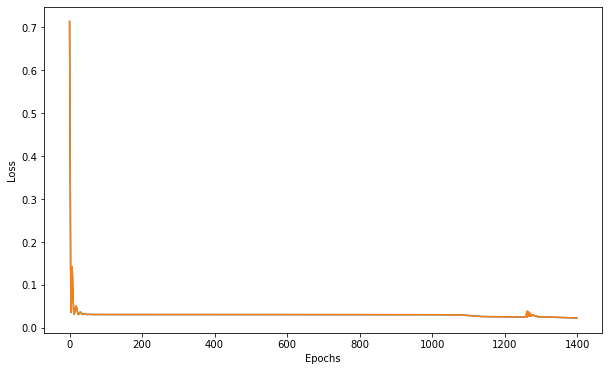

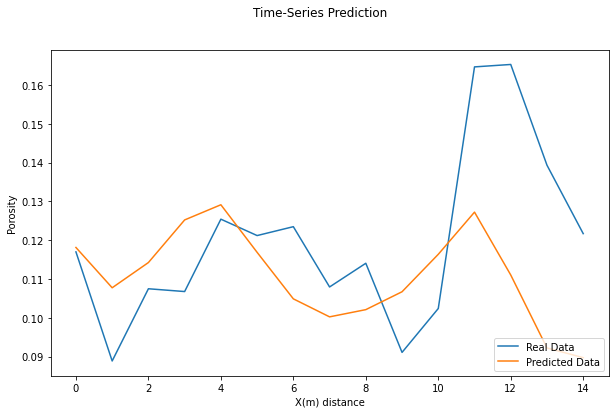

In [296]:
training_set = pd.read_csv('datasets/scaled_v2_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.126324631773632, pvalue=0.6537108048385534)
STD: 0.023308294
MSE: 0.0006241504


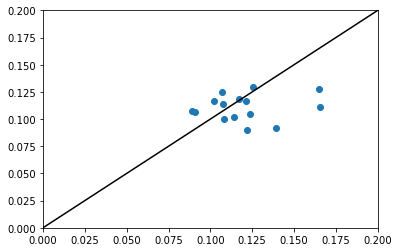

In [297]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.76561
Epoch: 100, loss: 0.04935
Epoch: 200, loss: 0.04935
Epoch: 300, loss: 0.04935
Epoch: 400, loss: 0.04934
Epoch: 500, loss: 0.04934
Epoch: 600, loss: 0.04933
Epoch: 700, loss: 0.04932
Epoch: 800, loss: 0.04928
Epoch: 900, loss: 0.04903
Epoch: 1000, loss: 0.01606
Epoch: 1100, loss: 0.00485
Epoch: 1200, loss: 0.00046
Epoch: 1300, loss: 0.00021


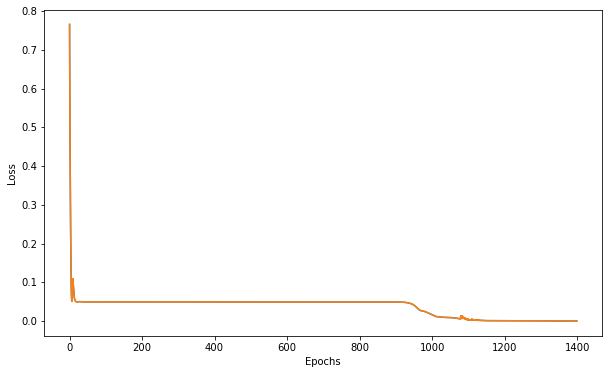

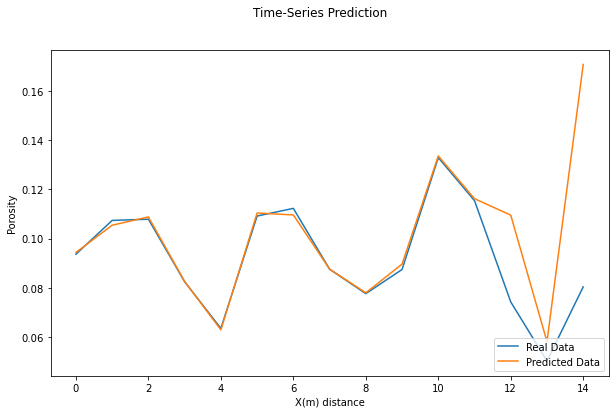

In [298]:
training_set = pd.read_csv('datasets/scaled_v2_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.5495605199080454, pvalue=0.03382668571183137)
STD: 0.023480749
MSE: 0.00063279393


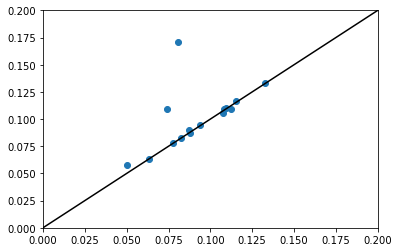

In [299]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.21165
Epoch: 100, loss: 0.06064
Epoch: 200, loss: 0.05208
Epoch: 300, loss: 0.04655
Epoch: 400, loss: 0.04516
Epoch: 500, loss: 0.04286
Epoch: 600, loss: 0.03683
Epoch: 700, loss: 0.03020
Epoch: 800, loss: 0.02559
Epoch: 900, loss: 0.02199
Epoch: 1000, loss: 0.01899
Epoch: 1100, loss: 0.01705
Epoch: 1200, loss: 0.01275
Epoch: 1300, loss: 0.01638


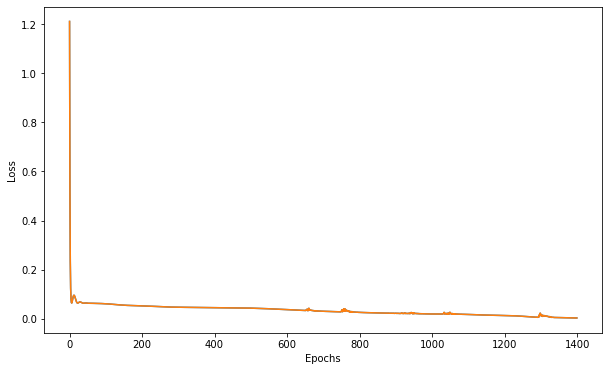

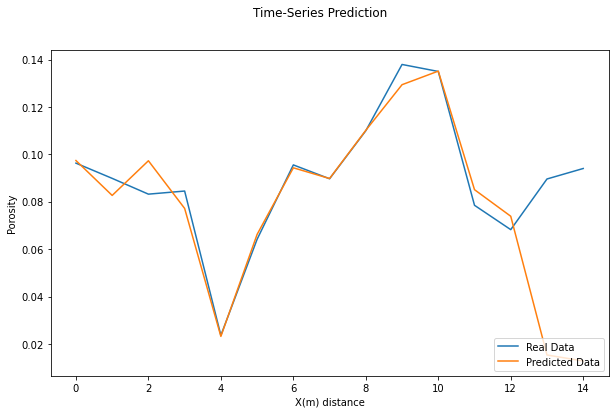

In [300]:
training_set = pd.read_csv('datasets/scaled_v2_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2


lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.6613189736339244, pvalue=0.00725810317477079)
STD: 0.02716089
MSE: 0.0008381132


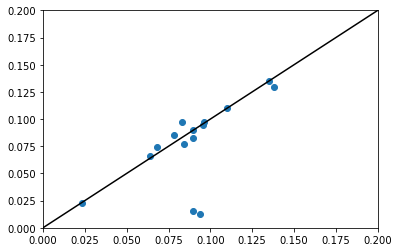

In [301]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.44573470843853397
Average MSE:  0.0006983525430162748


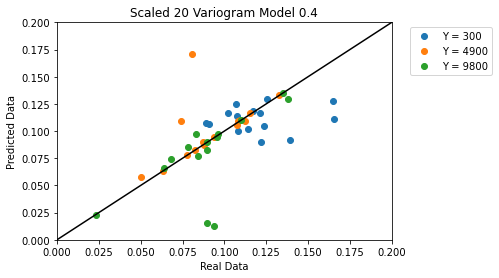

In [302]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 20 Variogram Model 0.4")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [303]:
con2 = np.concatenate((pred_d1, pred_d2, pred_d3))
real2 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.6 Scale 20

Epoch: 0, loss: 0.86675
Epoch: 100, loss: 0.02217
Epoch: 200, loss: 0.02211
Epoch: 300, loss: 0.02204
Epoch: 400, loss: 0.02193
Epoch: 500, loss: 0.02175
Epoch: 600, loss: 0.02139
Epoch: 700, loss: 0.02095
Epoch: 800, loss: 0.02070
Epoch: 900, loss: 0.02045
Epoch: 1000, loss: 0.02006
Epoch: 1100, loss: 0.02339
Epoch: 1200, loss: 0.01965
Epoch: 1300, loss: 0.01876


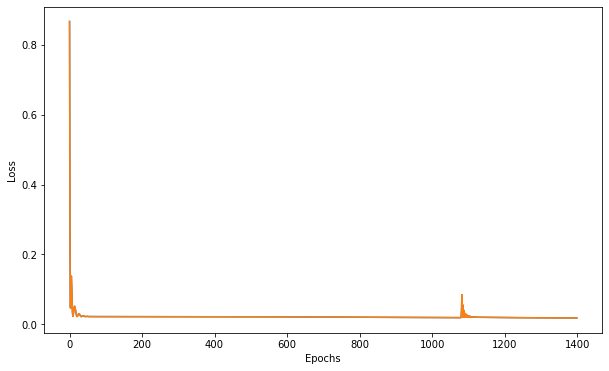

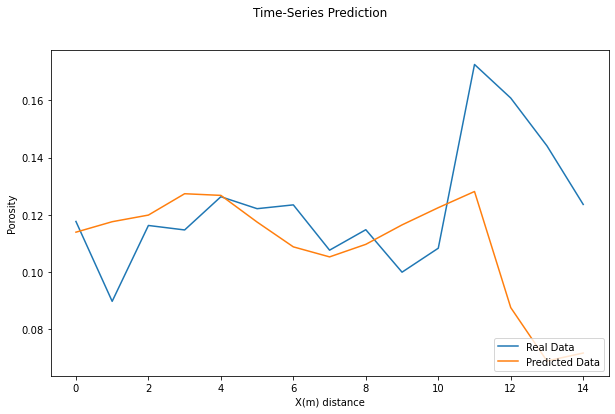

In [304]:
training_set = pd.read_csv('datasets/scaled_v3_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=-0.26579517550986087, pvalue=0.338320026642004)
STD: 0.031310968
MSE: 0.0011580089


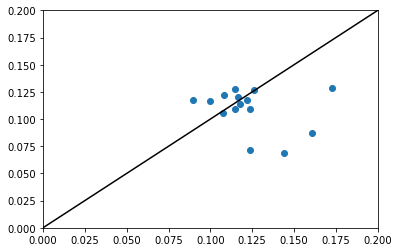

In [305]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.51238
Epoch: 100, loss: 0.03438
Epoch: 200, loss: 0.03377
Epoch: 300, loss: 0.03344
Epoch: 400, loss: 0.03310
Epoch: 500, loss: 0.03231
Epoch: 600, loss: 0.02819
Epoch: 700, loss: 0.02003
Epoch: 800, loss: 0.01751
Epoch: 900, loss: 0.01341
Epoch: 1000, loss: 0.01347
Epoch: 1100, loss: 0.00951
Epoch: 1200, loss: 0.00548
Epoch: 1300, loss: 0.00558


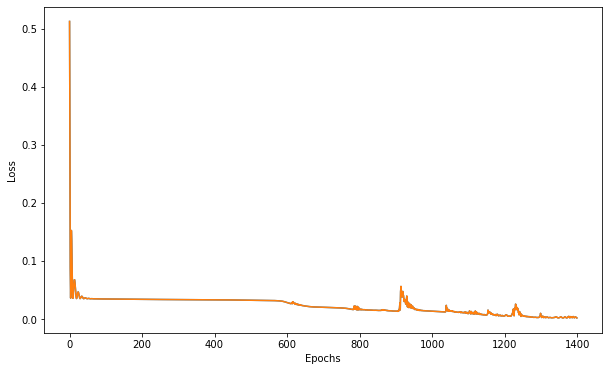

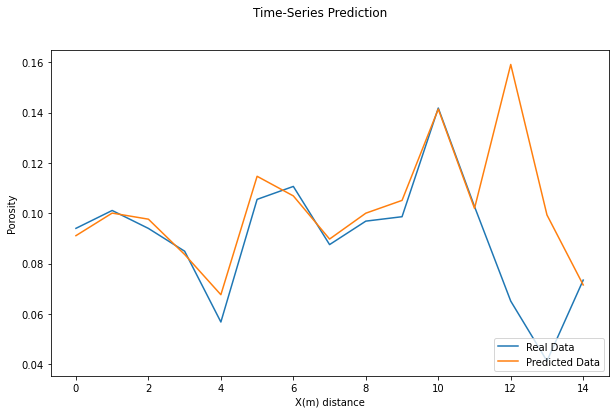

In [306]:
training_set = pd.read_csv('datasets/scaled_v3_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.3445468242687695, pvalue=0.20853545791895955)
STD: 0.02639627
MSE: 0.0008336104


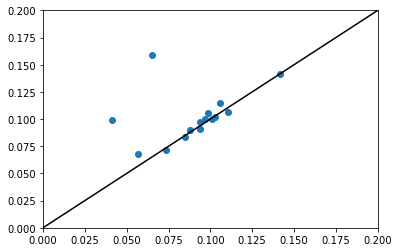

In [307]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.37288
Epoch: 100, loss: 0.05660
Epoch: 200, loss: 0.05148
Epoch: 300, loss: 0.04553
Epoch: 400, loss: 0.03585
Epoch: 500, loss: 0.03121
Epoch: 600, loss: 0.02824
Epoch: 700, loss: 0.02589
Epoch: 800, loss: 0.02329
Epoch: 900, loss: 0.00759
Epoch: 1000, loss: 0.00513
Epoch: 1100, loss: 0.00355
Epoch: 1200, loss: 0.00230
Epoch: 1300, loss: 0.00143


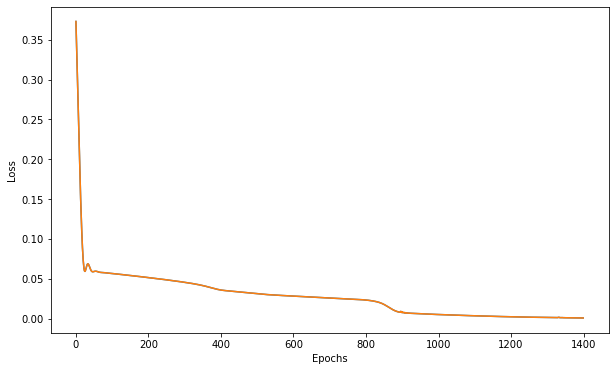

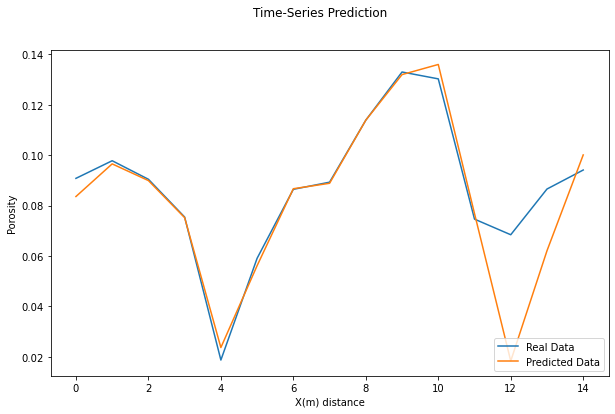

In [308]:
training_set = pd.read_csv('datasets/scaled_v3_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9034918000841132, pvalue=3.900610556258058e-06)
STD: 0.014029736
MSE: 0.00021806733


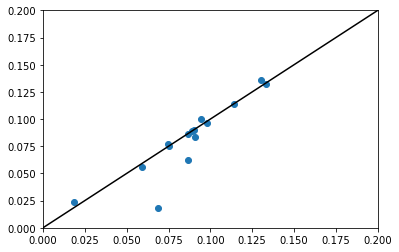

In [309]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.4581210853755049
Average MSE:  0.0005586093757301569


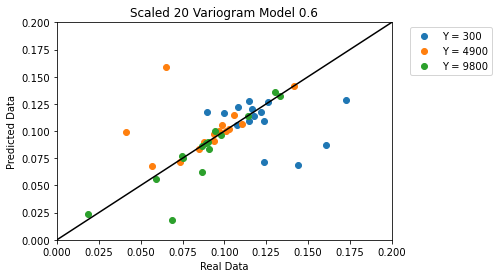

In [310]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 20 Variogram Model 0.6")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [311]:
con3 = np.concatenate((pred_d1, pred_d2, pred_d3))
real3 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.8 Scale 20

Epoch: 0, loss: 0.61818
Epoch: 100, loss: 0.02245
Epoch: 200, loss: 0.02239
Epoch: 300, loss: 0.02234
Epoch: 400, loss: 0.02229
Epoch: 500, loss: 0.02223
Epoch: 600, loss: 0.02217
Epoch: 700, loss: 0.02210
Epoch: 800, loss: 0.02203
Epoch: 900, loss: 0.02197
Epoch: 1000, loss: 0.02189
Epoch: 1100, loss: 0.02182
Epoch: 1200, loss: 0.02174
Epoch: 1300, loss: 0.02164


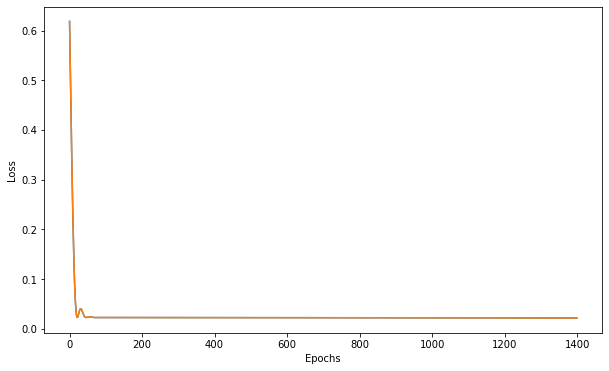

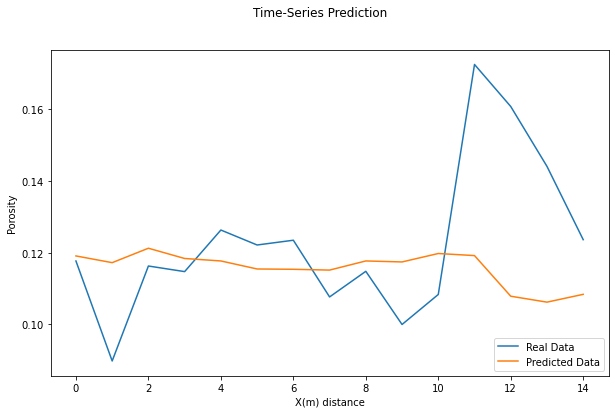

In [360]:
training_set = pd.read_csv('datasets/scaled_v4_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=-0.396555172873895, pvalue=0.14335506323691075)
STD: 0.023154762
MSE: 0.00058617734


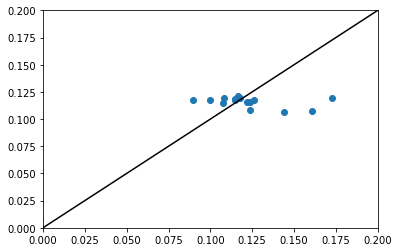

In [361]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.03503
Epoch: 100, loss: 0.03184
Epoch: 200, loss: 0.00105
Epoch: 300, loss: 0.00048
Epoch: 400, loss: 0.00038
Epoch: 500, loss: 0.00024
Epoch: 600, loss: 0.00019
Epoch: 700, loss: 0.00016
Epoch: 800, loss: 0.00005
Epoch: 900, loss: 0.00002
Epoch: 1000, loss: 0.00001
Epoch: 1100, loss: 0.00001
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


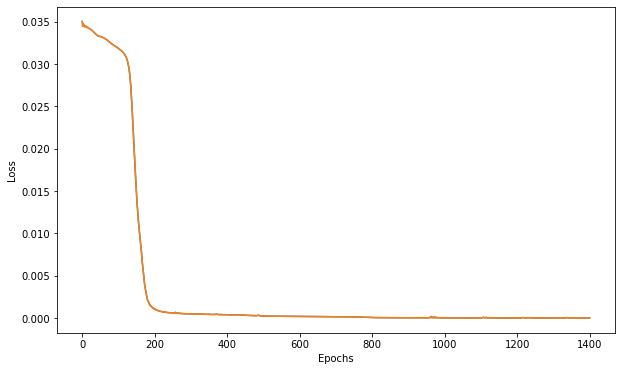

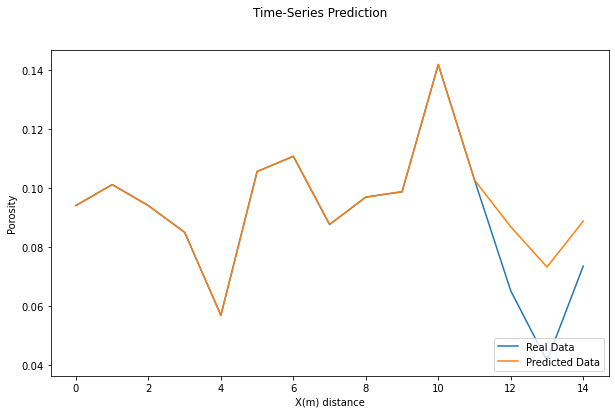

In [362]:
training_set = pd.read_csv('datasets/scaled_v4_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9230350389870242, pvalue=9.404125715674564e-07)
STD: 0.009665533
MSE: 0.00011439424


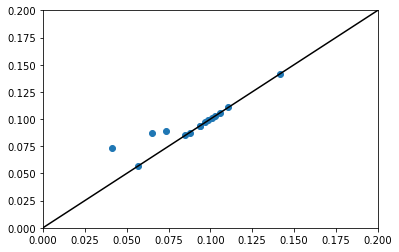

In [363]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.65731
Epoch: 100, loss: 0.06283
Epoch: 200, loss: 0.06079
Epoch: 300, loss: 0.05800
Epoch: 400, loss: 0.05489
Epoch: 500, loss: 0.05202
Epoch: 600, loss: 0.04968
Epoch: 700, loss: 0.04781
Epoch: 800, loss: 0.04619
Epoch: 900, loss: 0.04451


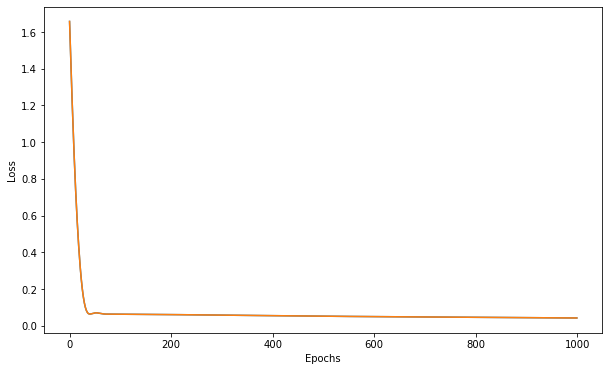

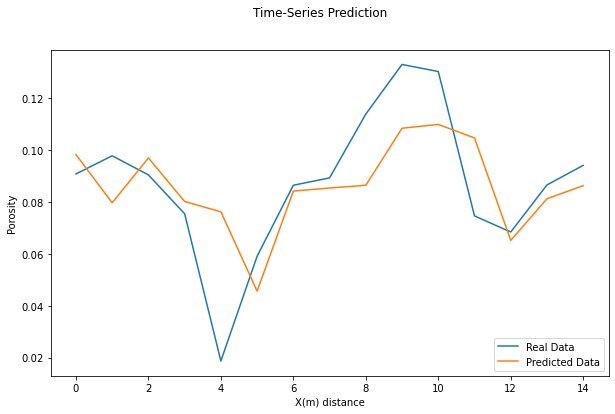

In [364]:
training_set = pd.read_csv('datasets/scaled_v4_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.6245811487278876, pvalue=0.012805171120151213)
STD: 0.02114614
MSE: 0.0004489694


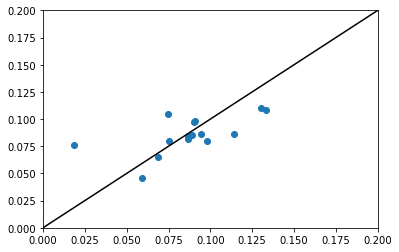

In [365]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.3836870049470056
Average MSE:  0.000383180333301425


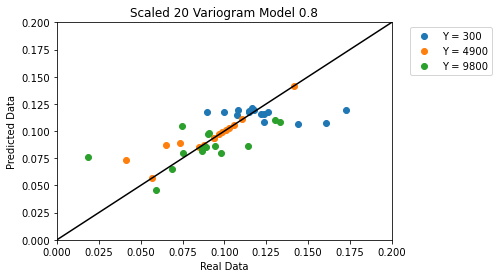

In [366]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 20 Variogram Model 0.8")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [319]:
con4 = np.concatenate((pred_d1, pred_d2, pred_d3))
real4 = np.concatenate((real_d1, real_d2, real_d3))

### Total Scaled 20 Performance

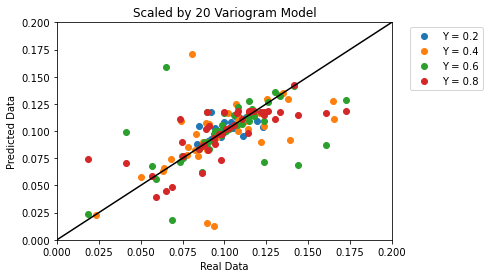

In [320]:
plt.plot(real1, con1, 'o', label = 'Y = 0.2')
plt.plot(real2, con2, 'o', label = 'Y = 0.4')
plt.plot(real3, con3, 'o', label = 'Y = 0.6')
plt.plot(real4, con4, 'o', label = 'Y = 0.8')
#plt.plot(real1, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
#pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
#mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
#print('Average Pearson: ', pearson_02_n)
#print('Average MSE: ', mse_02_n)
plt.title("Scaled by 20 Variogram Model")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

## Scale 10

In [321]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [322]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        #self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        
        return out

## Variogram 0.2 Scaled 10

Epoch: 0, loss: 0.32824
Epoch: 100, loss: 0.02479
Epoch: 200, loss: 0.01876
Epoch: 300, loss: 0.01003


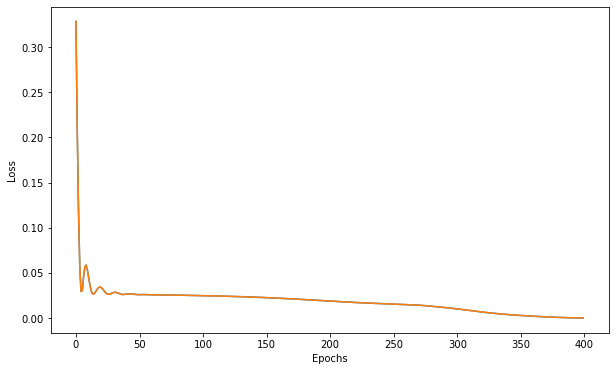

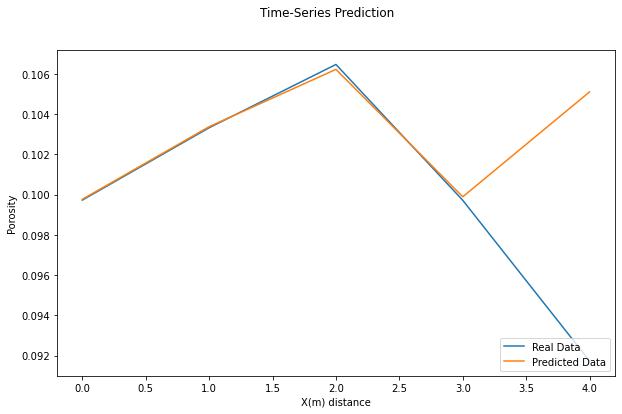

In [323]:
training_set = pd.read_csv('datasets/scaled_v1_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.1009375355932226, pvalue=0.8717009041276307)
STD: 0.005351293
MSE: 3.582272e-05


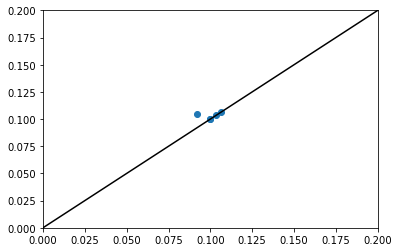

In [325]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.78008
Epoch: 100, loss: 0.04228
Epoch: 200, loss: 0.03257
Epoch: 300, loss: 0.03006


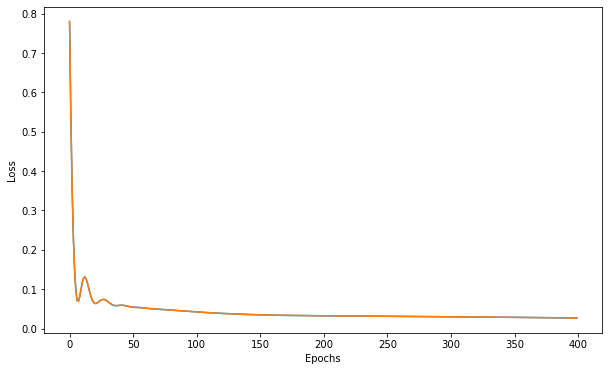

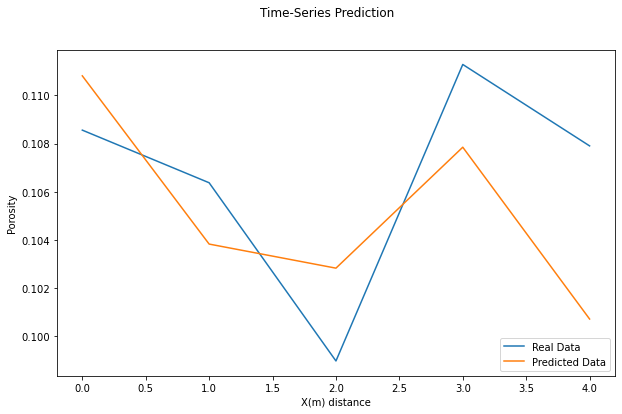

In [326]:
training_set = pd.read_csv('datasets/scaled_v1_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.47762730679764653, pvalue=0.41585199855541455)
STD: 0.003997884
MSE: 1.7977714e-05


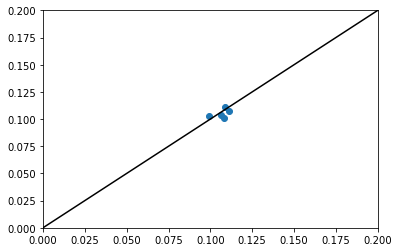

In [327]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.30685
Epoch: 100, loss: 0.00151
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000


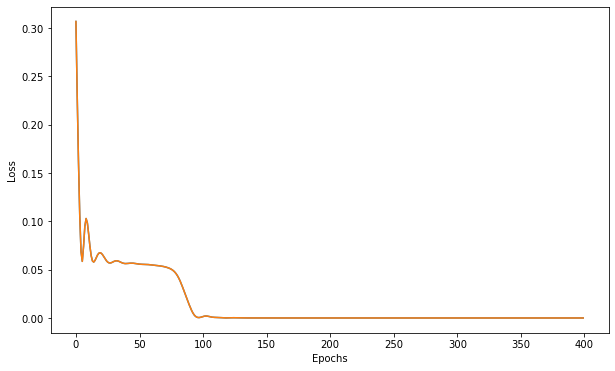

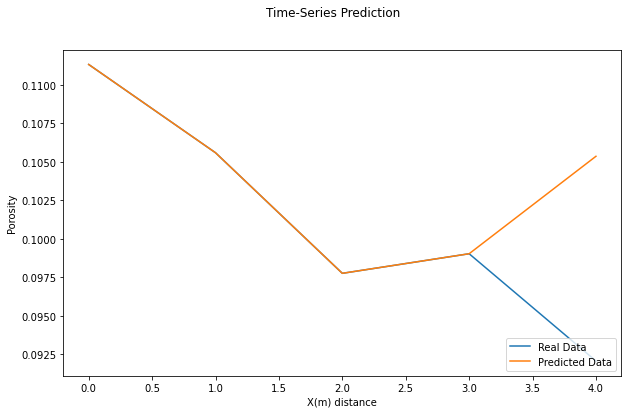

In [328]:
training_set = pd.read_csv('datasets/scaled_v1_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.6148914506758102, pvalue=0.26969593640173617)
STD: 0.0053231567
MSE: 3.5419995e-05


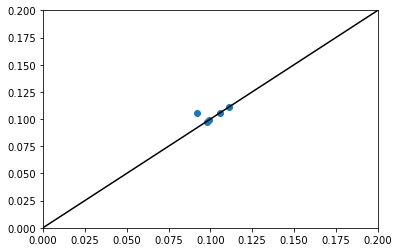

In [329]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.39781876435555974
Average MSE:  2.97401420539245e-05


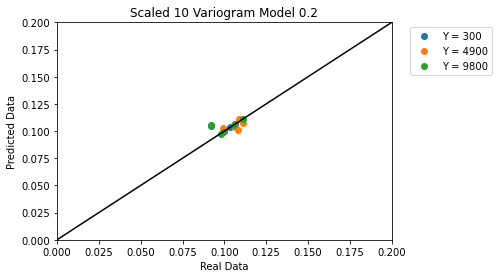

In [330]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 10 Variogram Model 0.2")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [331]:
con1 = np.concatenate((pred_d1, pred_d2, pred_d3))
real1 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.4 Scale 10

Epoch: 0, loss: 0.53952
Epoch: 100, loss: 0.00480
Epoch: 200, loss: 0.00478
Epoch: 300, loss: 0.00478


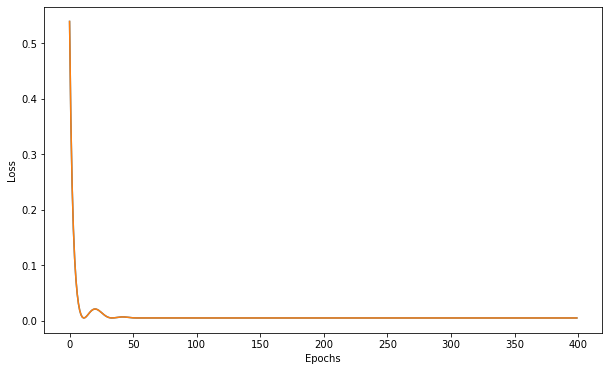

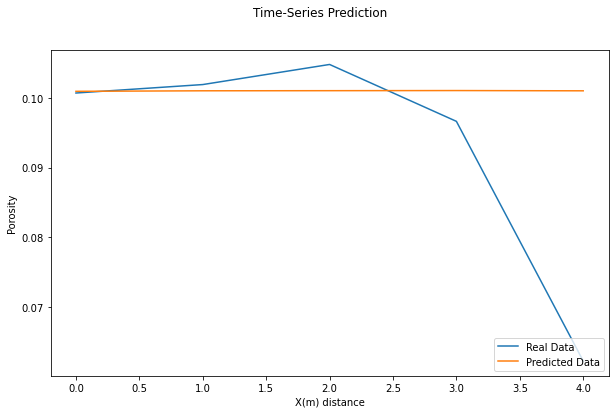

In [332]:
training_set = pd.read_csv('datasets/scaled_v2_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=-0.06164467533554268, pvalue=0.9215613002218952)
STD: 0.015711823
MSE: 0.00030686968


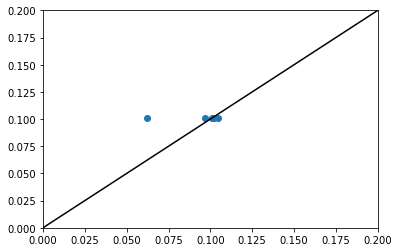

In [333]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.33231
Epoch: 100, loss: 0.06278
Epoch: 200, loss: 0.02015
Epoch: 300, loss: 0.00456


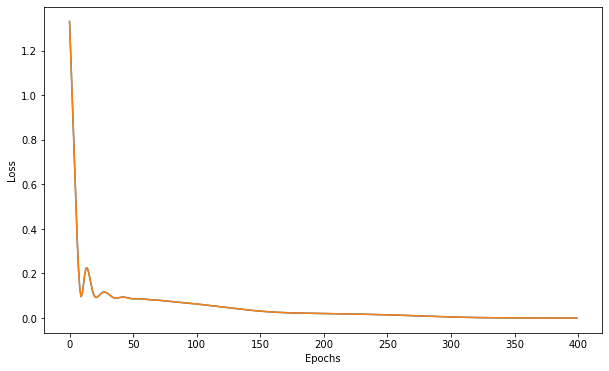

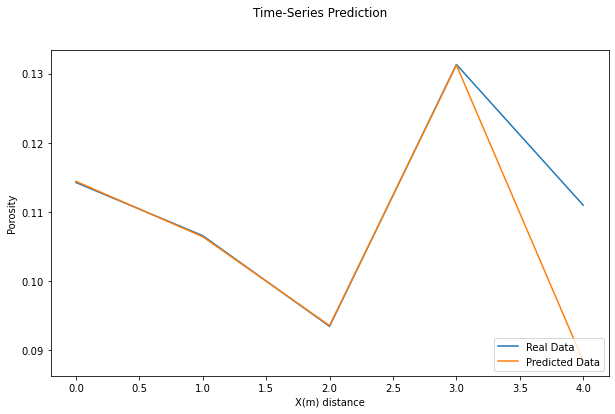

In [334]:
training_set = pd.read_csv('datasets/scaled_v2_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8073888786197411, pvalue=0.09849009460156415)
STD: 0.009010854
MSE: 0.00010142076


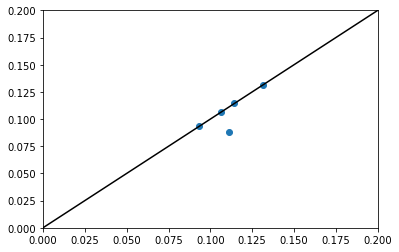

In [335]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.29735
Epoch: 100, loss: 0.00009
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000


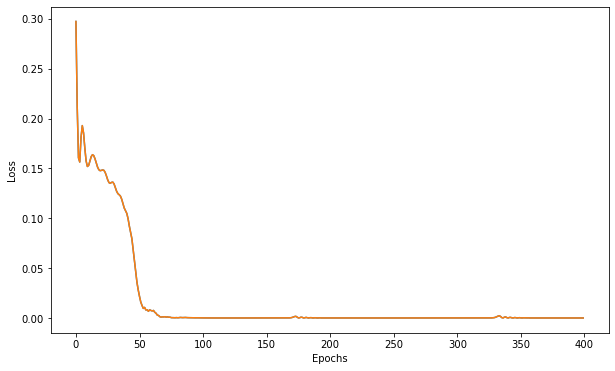

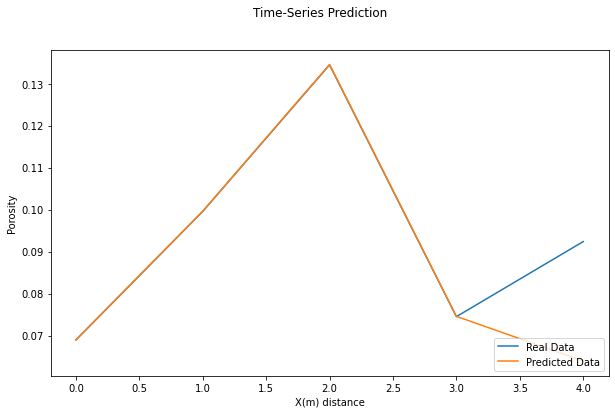

In [336]:
training_set = pd.read_csv('datasets/scaled_v2_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9002520091639878, pvalue=0.03724629385568265)
STD: 0.011405013
MSE: 0.00016192027


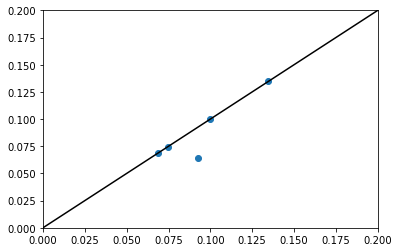

In [337]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.5486654041493955
Average MSE:  0.00019007024820894003


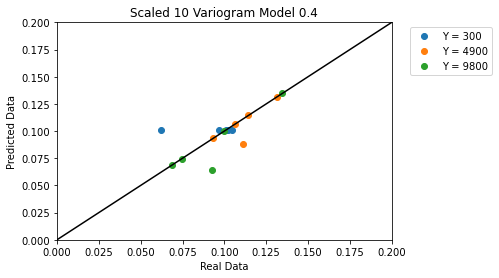

In [338]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 10 Variogram Model 0.4")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [339]:
con2 = np.concatenate((pred_d1, pred_d2, pred_d3))
real2 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.6 Scale 10

Epoch: 0, loss: 2.32071
Epoch: 100, loss: 0.01220
Epoch: 200, loss: 0.01211
Epoch: 300, loss: 0.01206


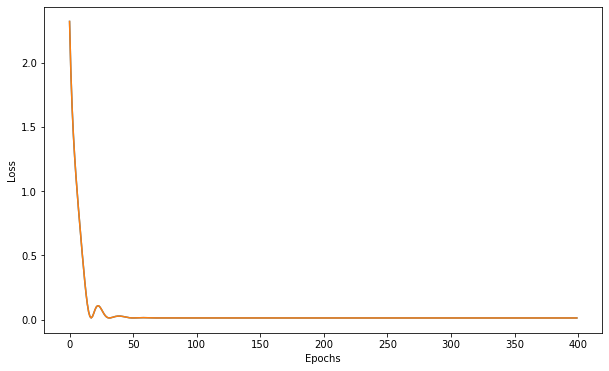

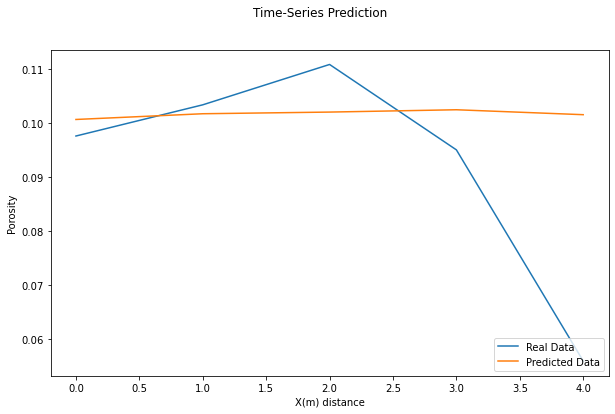

In [369]:
training_set = pd.read_csv('datasets/scaled_v3_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.14949364709020183, pvalue=0.8103701413873222)
STD: 0.01903711
MSE: 0.00044585438


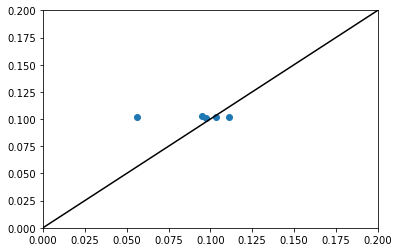

In [370]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.28447
Epoch: 100, loss: 0.06712
Epoch: 200, loss: 0.01985
Epoch: 300, loss: 0.01447


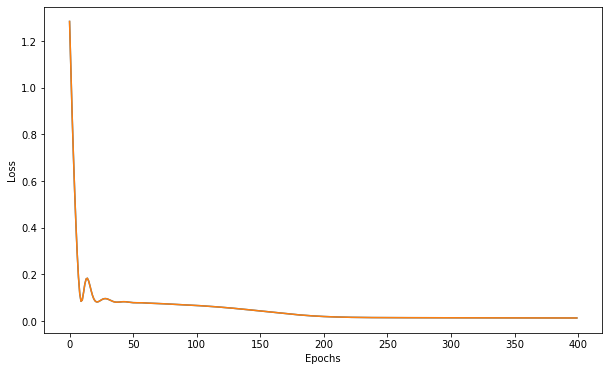

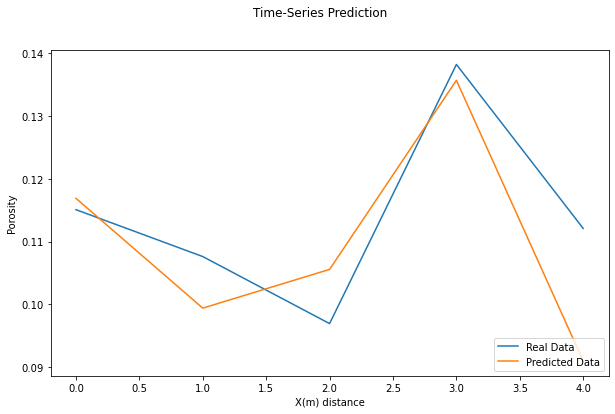

In [371]:
training_set = pd.read_csv('datasets/scaled_v3_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7685367821714503, pvalue=0.12893533928720322)
STD: 0.010066682
MSE: 0.00011971452


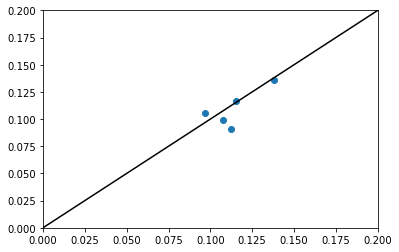

In [372]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.15239
Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000


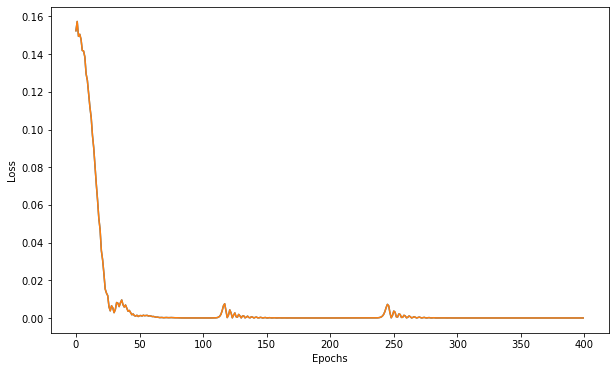

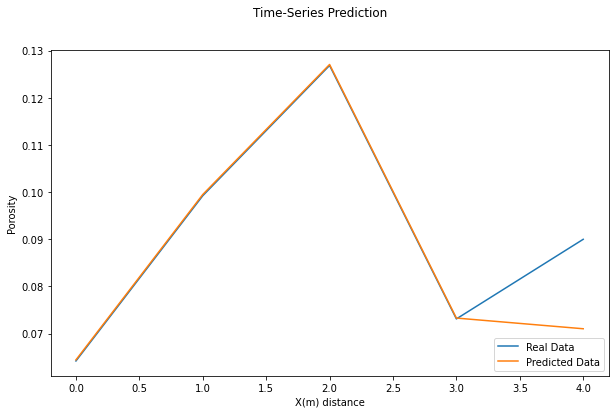

In [373]:
training_set = pd.read_csv('datasets/scaled_v3_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9442024886870675, pvalue=0.015688718060701975)
STD: 0.007679047
MSE: 7.207772e-05


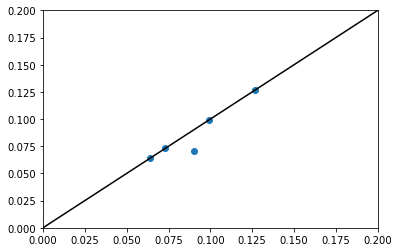

In [374]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.6207443059829065
Average MSE:  0.00021254888270050287


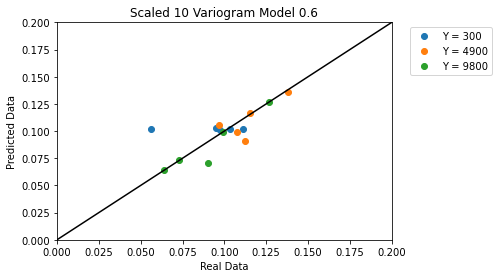

In [375]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 10 Variogram Model 0.6")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [376]:
con3 = np.concatenate((pred_d1, pred_d2, pred_d3))
real3 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.8 Scale 10

Epoch: 0, loss: 0.69402
Epoch: 100, loss: 0.01206
Epoch: 200, loss: 0.01204
Epoch: 300, loss: 0.01201


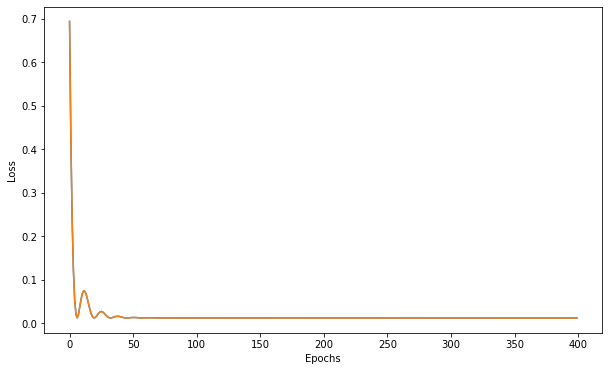

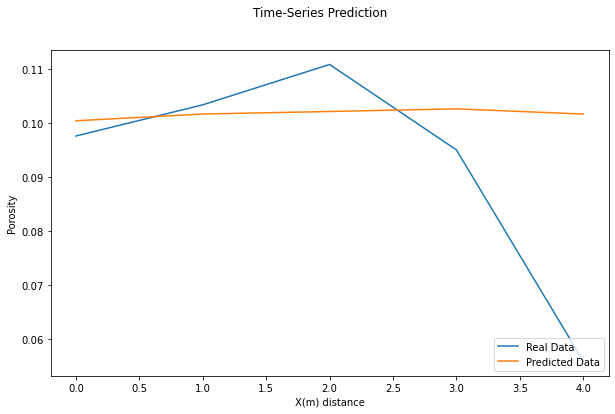

In [348]:
training_set = pd.read_csv('datasets/scaled_v4_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.06950450089520671, pvalue=0.9115754247417512)
STD: 0.019080423
MSE: 0.00044787783


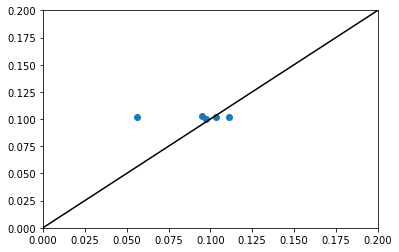

In [349]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0] 
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.65410
Epoch: 100, loss: 0.06560
Epoch: 200, loss: 0.00257
Epoch: 300, loss: 0.00000


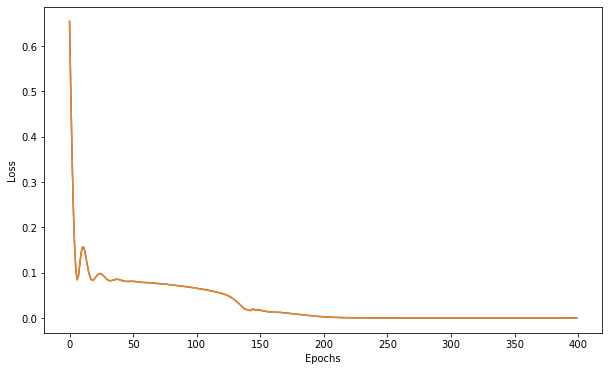

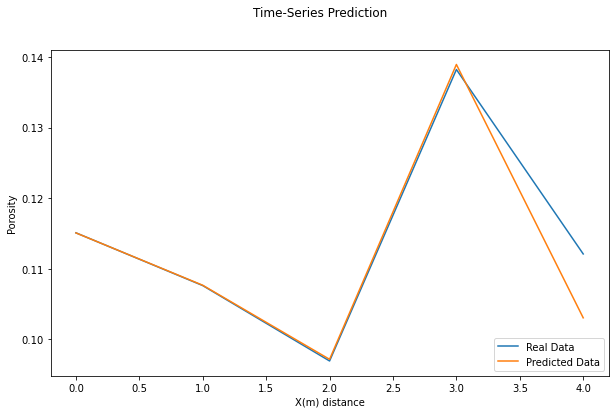

In [350]:
training_set = pd.read_csv('datasets/scaled_v4_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9669714278310673, pvalue=0.0071697691408451475)
STD: 0.0037287464
MSE: 1.650902e-05


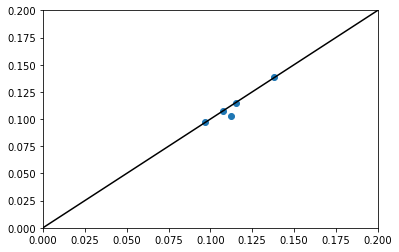

In [351]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.53998
Epoch: 100, loss: 0.14738
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000


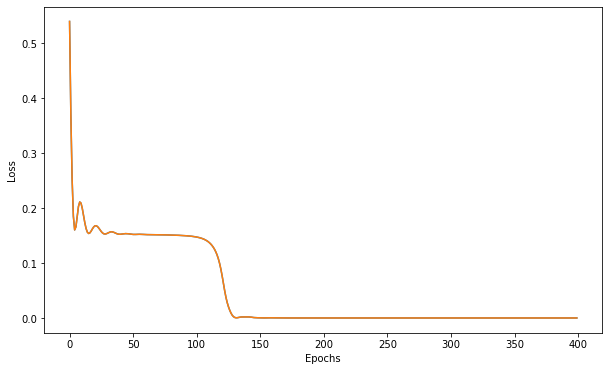

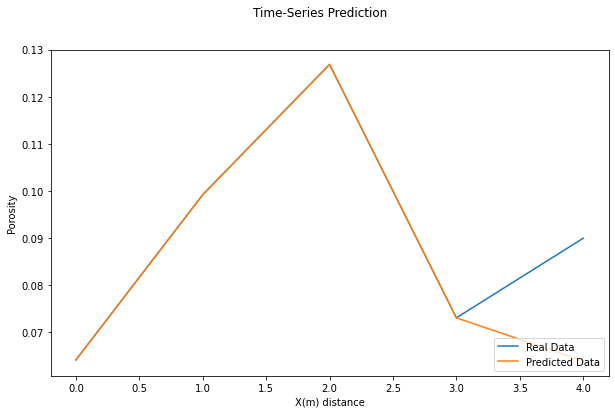

In [352]:
training_set = pd.read_csv('datasets/scaled_v4_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9041469231257665, pvalue=0.0351073533977629)
STD: 0.010419751
MSE: 0.00013571398


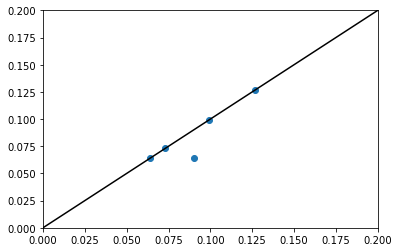

In [353]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.6468742839506801
Average MSE:  0.00020003361472239098


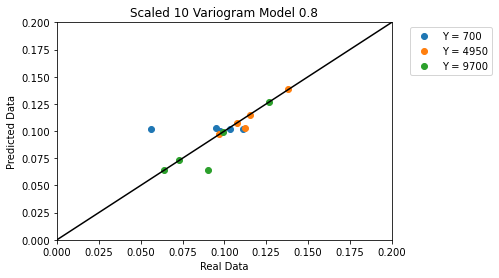

In [354]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 700')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4950')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9700')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 10 Variogram Model 0.8")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [355]:
con4 = np.concatenate((pred_d1, pred_d2, pred_d3))
real4 = np.concatenate((real_d1, real_d2, real_d3))

### Total Scaled 10 

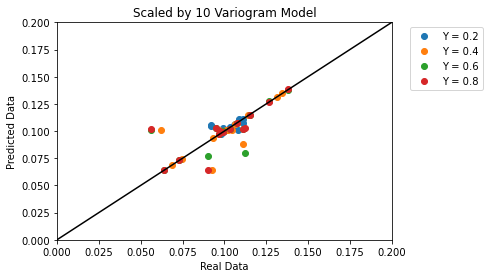

In [356]:
plt.plot(real1, con1, 'o', label = 'Y = 0.2')
plt.plot(real2, con2, 'o', label = 'Y = 0.4')
plt.plot(real3, con3, 'o', label = 'Y = 0.6')
plt.plot(real4, con4, 'o', label = 'Y = 0.8')
#plt.plot(real1, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
#pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
#mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
#print('Average Pearson: ', pearson_02_n)
#print('Average MSE: ', mse_02_n)
plt.title("Scaled by 10 Variogram Model")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

# Response Surface

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import matplotlib.font_manager

In [2]:
plt.style.use('https://raw.githubusercontent.com/emaldonadocruz/Publication_figure_style/master/Publication_figure_style.mplstyle')

In [3]:
data = [[0.03, 0.2, .00094861], [0.03, 0.2,.0002751757274], [0.03, 0.2,.0000910609204], [0.03, 0.2, 0.0000764241151], [0.06, 0.25, .00026566], [0.06, 0.25, .00017617], [0.06, 0.25,0.0000961994373 ], [0.06, 0.25, .00015604], [0.1, 0.2, 0.0000458918366], [0.1, 0.2,.00069835 ], [0.1, 0.2, .00055861], [0.1, 0.2,.00038318], [0.05, 0.0, 0.00002974014205], [0.05, 0.0, .0001900702], [0.05, 0.0, .00021254], [0.05, 0.0, .00020003361]]

In [4]:
df = pd.DataFrame(data, columns=['learning_rate', 'Dropout', 'MSE']) 

In [5]:
df

learning_rate  Dropout       MSE
0            0.03     0.20  0.000949
1            0.03     0.20  0.000275
2            0.03     0.20  0.000091
3            0.03     0.20  0.000076
4            0.06     0.25  0.000266
5            0.06     0.25  0.000176
6            0.06     0.25  0.000096
7            0.06     0.25  0.000156
8            0.10     0.20  0.000046
9            0.10     0.20  0.000698
10           0.10     0.20  0.000559
11           0.10     0.20  0.000383
12           0.05     0.00  0.000030
13           0.05     0.00  0.000190
14           0.05     0.00  0.000213
15           0.05     0.00  0.000200

<ipython-input-8-923f7cd4bf7f>:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


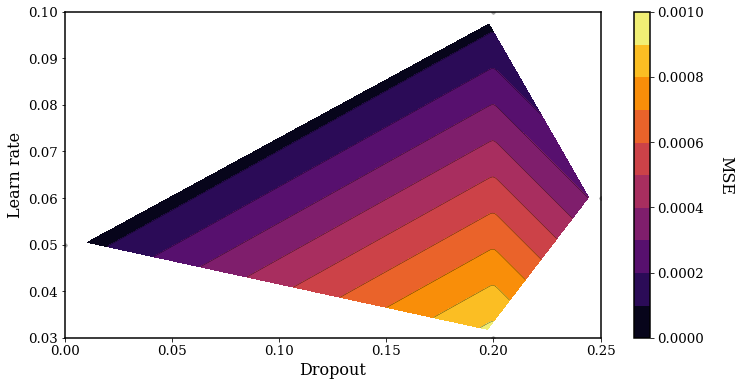

In [8]:
import scipy.ndimage
import matplotlib.tri as tri
from scipy.ndimage.filters import gaussian_filter
metric = 'MSE'
z=df['MSE'].values
y=df['learning_rate'].values
x=df['Dropout'].values

fig, (ax1) = plt.subplots(nrows=1,figsize=(12,6))

npoints=2000
smooth=8

# Create grid values first.
xi = np.linspace(x.min(), x.max(), npoints)
yi = np.linspace(y.min(), y.max(), npoints)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

zi = gaussian_filter(zi, smooth)

levels=9

ax1.contour(xi, yi, zi, levels=levels, linewidths=0.3, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=levels, cmap="inferno")

#fig.colorbar(cntr1, ax=ax1)
cbar = plt.colorbar(cntr1, ax=ax1)
cbar.set_label('MSE', rotation=270,labelpad=30)
#cbar.ax.set_ylim(0.08,1.02)

ax1.set(xlim=(df.Dropout.min(), df.Dropout.max()),ylim=(df.learning_rate.min(), df.learning_rate.max()))
ax1.scatter(x,y,s=7,color='darkgray')
ax1.set_ylabel('Learn rate')
ax1.set_xlabel('Dropout')

#plt.savefig(metric+'_L1.tiff',dpi=300)

plt.show()